# Symulacje Komputerowe - Raport
Konstanty Andrzejczak, Tomasz Srebrniak, Aleksandra Zachajska

## Cel:
W prezentowanej pracy celem jest rozwiązanie sześciu zadanych zagadnień za pomocą metod poznanych na przedmiocie "Symulacje komputerowe". 

Na początku zadeklarujemy wszystkie biblioteki z jakich będziemy korzystać w poniższym raporcie.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.integrate as integrate
import typing
import time
from scipy.special import lambertw

## 1: Generator ACORN (Additive Congruential Random Number)

### Cel
W pierwszym prezentowanym problemie mamy za zadanie zaimplementowanie generatora jako funkcję $ACORN(N, k, M, Lag)$ zwracającą N liczb pseudolosowych $Y_{n}^k$, dla n = 1,$\ldots, N$, korzystając z algorytmu k-tego rzędu, przy ominięciu pierwszych $Lag$ wyrazów. Przykładowymi parametrami z jakich mamy skorzystać mogą być $M=2^{89}−1$ (liczba pierwsza Mersenne’a), k = 9, $X_{0}^m = 0$ dla $m=0$ (mogą być dowolne), $Lag = 10^3$. Następnie mamy sprawdzić poprawność wyniku robiąc wykresy ciągu $Y_n^k$, funkcji $Y_{n-1}^k -> Y_n^k$ oraz histogramy. Na sam koniec postaramy się porównać wydajność z wbudowanym generatorem numpy. 

### Rozwiązanie
Zaczniemy rozwiązanie tego zagdanienia od głównego celu zadania mianowicie od zaimplementowania funkcji generującej ciąg liczb pseudolosowych $ACORN$.

In [108]:
def ACORN(N: int, k: int = 9, M: int = 2**89-1, Lag: int = 10000) -> np.ndarray:
    """
    Funkcja ACORN generuje ciąg liczb pseudolosowych przy użyciu algorytmu ACORN (Additive Congruential Random Number).

    INPUT:
        N (int): Liczba liczb pseudolosowych do wygenerowania.
        k (int): Liczba warstw w algorytmie ACORN. Domyślna wartość to 9.
        M (int): Moduł do obliczeń. Domyślna wartość to 2**89 - 1.
        Lag (int): Opóźnienie, czyli liczba początkowych wartości do pominięcia. Domyślna wartość to 10000.

    OUTPUT:
        np.ndarray: Tablica liczb pseudolosowych o długości N.
    """
    seed = np.random.randint(1, 2**30)
    Xs = np.zeros((k+1, N+Lag))
    Xs[0, :] = seed
    for m in range(1, k+1):
        for n in range(1, N+Lag):
            Xs[m, n] = (Xs[m-1, n] + Xs[m, n-1]) % M
    return Xs[k, Lag:] / M

#### Wizualizacja liczb pseudolosowych

Wywołajmy funkcję dla przykladowych parametrów.

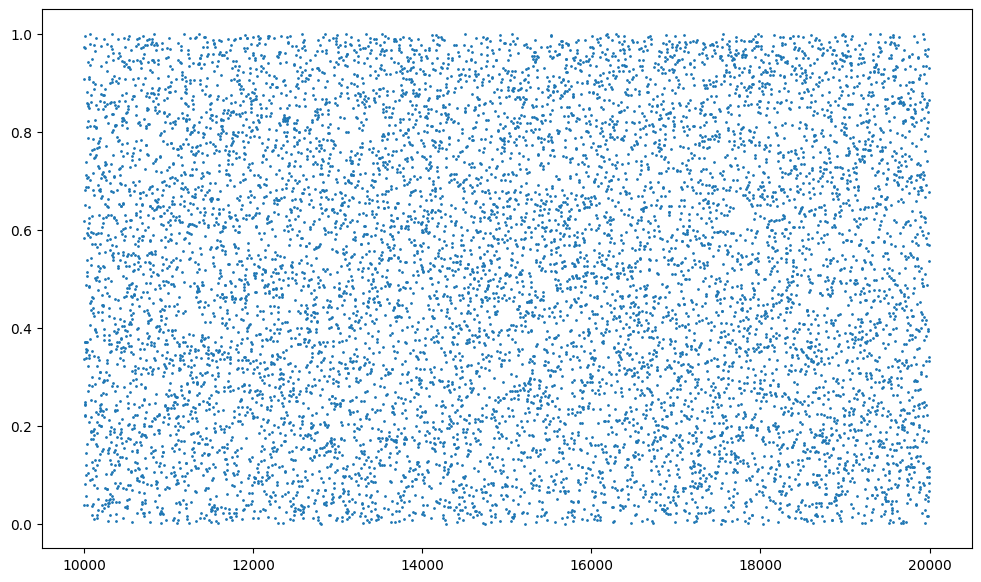

In [109]:
N = 10000
Xs = ACORN(N)
fig, ax = plt.subplots()
ax.scatter(np.arange(10000, N+10000, 1), Xs, s=1)
plt.show()

#### Wizualizacja zależności między kolejnymi wygenerowanymi liczbami

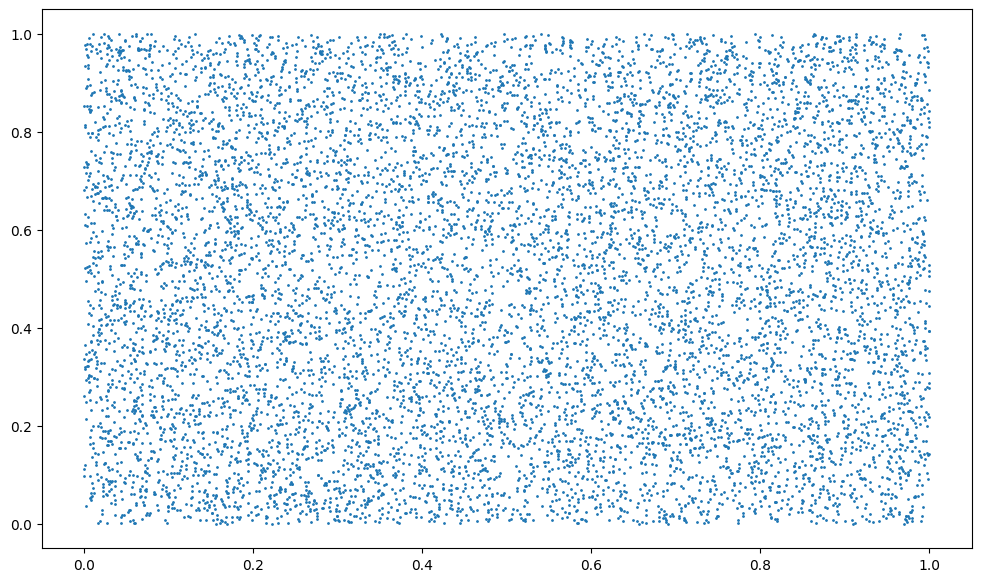

In [110]:
N = 10000
Xs = ACORN(N)
fig, ax = plt.subplots()
ax.scatter(Xs[:-1], Xs[1:], s=1)
plt.show()

#### Histogram rozkładu częstości występowania liczb pseudolosowych

<Axes: ylabel='Density'>

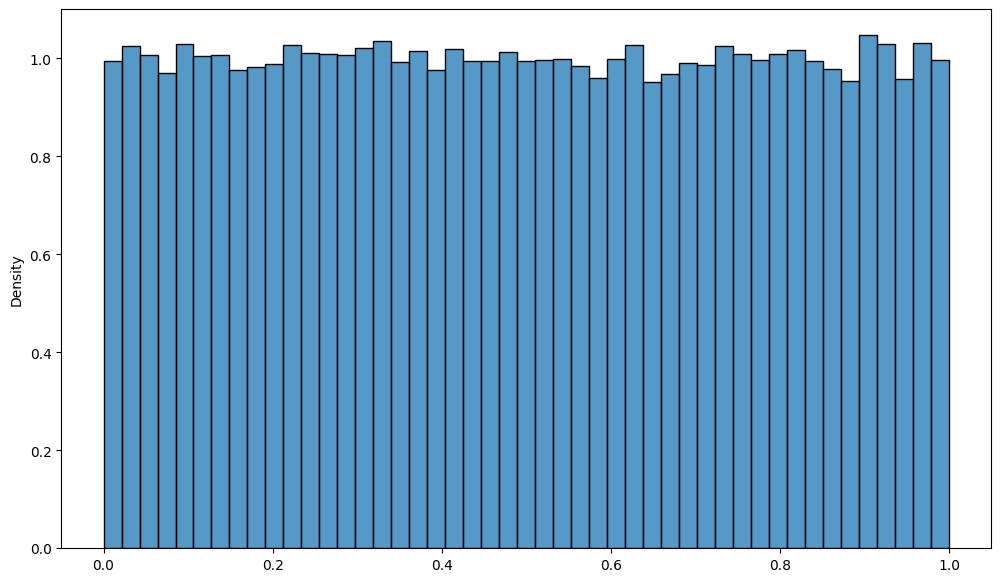

In [111]:
N = 100000
Xs = ACORN(N)
fig, ax = plt.subplots()
sns.histplot(Xs, stat='density', ax=ax)

Z powyższych wykresów można wywnioskować, że rozkład wygenerowanych zmiennych losowych jest równomierny. Nie widać znacznych różnic w wysokościach słupków prezentowanych na histogramie. Jest to pozytywny wniosek i oczekiwana obserwacja. Teraz postaramy się porównać wydajność z wbudowanym generatorem numpy. W tym celu skorzystamy z funkcji time z biblioteki time.

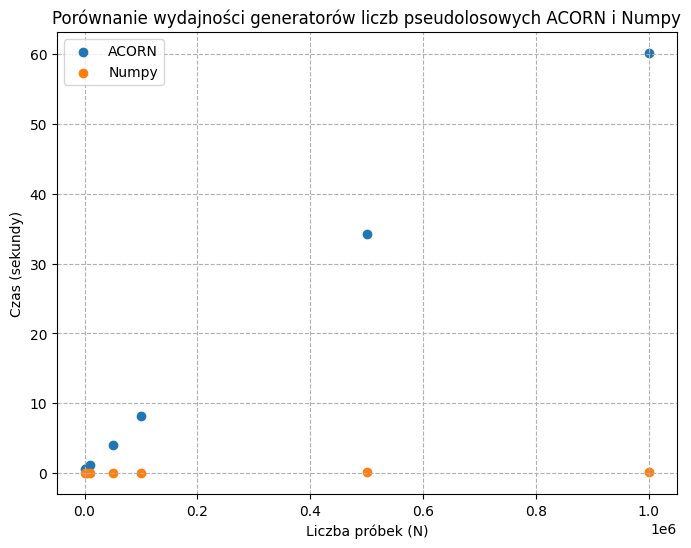

In [112]:
def measure_performance() -> typing.Tuple[typing.List[int], typing.List[float], typing.List[float]]:
    """
    Mierzy wydajność generowania losowych liczb przez ACORN i Numpy dla różnych wartości N.

    OUTPUTS:
        N_values: Lista wartości N, dla których są mierzone czasy wykonania.
        acorn_times: Lista czasów wykonania dla ACORN (w sekundach).
        numpy_times: Lista czasów wykonania dla Numpy (w sekundach).
    """
    N_values = [1000, 5000, 10000, 50000, 100000, 500000]
    acorn_times = []
    numpy_times = []

    for N in N_values:
        start_time = time.time()
        _ = ACORN(N)
        acorn_time = time.time() - start_time
        acorn_times.append(acorn_time)

        start_time = time.time()
        _ = np.random.rand(N) * (2**89 - 1)
        numpy_time = time.time() - start_time
        numpy_times.append(numpy_time)
        
    return N_values, acorn_times, numpy_times

N_values, acorn_times, numpy_times = measure_performance()

plt.figure(figsize=(8, 6))
plt.scatter(N_values, acorn_times, label='ACORN', marker='o')
plt.scatter(N_values, numpy_times, label='Numpy', marker='o')
plt.xlabel('Liczba próbek (N)')
plt.ylabel('Czas (sekundy)')
plt.title('Porównanie wydajności generatorów liczb pseudolosowych ACORN i Numpy')
plt.legend()
plt.grid(linestyle="--")
plt.show()

Porównanie czasów prowadzi do konkluzji, że czas realizacji generowania liczb pseudolosowych za pomocą biblioteki numpy jest zawsze bliski zera, nawet przy wysokich wartościach ilości próbek. Natomiast czas realizacji generowania za pomocą metody ACORN rośnie liniowo wraz ze wzrostem liczby próbek. 

## 2: Generowanie rozkładu normalnego

### Cel
W drugim zadaniu sprawdzimy dotychczas zaimplementowane algorytmy przedstawiające kilka metod generowania rozkładu normalnego. Następnie postaramy się stworzyć dwie dodatkowe metody, mianowicie 
- metodę "tuzina",
- metodę zigguratu.
 
Finalnie porównamy efektywność generowania za pomocą kolejnych metod. 

### Rozwiązanie
Zaczynając rozwiązanie problemu rozpoczniemy od weryfikacji poprawności działania dotychczas zaimplementowanych metod. Jednak zanim, skonfigurujemy niektóre z ustawień dla biblioteki Matplotlib. W poniższej komórce zadeklarowane zostały polecenia mające na celu ułatwienie późniejszych manipulacji w obrębie wykresów w związku z korzystaniem formatowania wyrażeń za pomocą LaTeX.

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.figsize'] = [12, 8]

Przechodząc do właściwego kodu. Jako pierwsza została zadeklarowana funkcja norm_inv_cdf która generuje liczby z rozkładu normalnego za pomocą metody odwrotnej dystrybuanty. Tutaj posłużyliśmy się biblioteką scipy. 

In [3]:
def norm_inv_cdf(size, mu=0, sigma=1):
    """
    Generuje n liczb z rozkładu normalnego o parametrach mu i sigma przy pomocy metody odwrotnej dystrybuanty.

    :param n: (int) liczba liczb do wygenerowania
    :param mu: (float) wartość oczekiwana
    :param sigma: (float) odchylenie standardowe
    :return: (np.ndarray) n liczb z rozkładu normalnego
    """
    
    us = stats.uniform.rvs(size=size)
    return stats.norm.ppf(us, loc=mu, scale=sigma)

Drugą metodą poznaną na zajęciach jest metoda Boxa-Mullera prezentowana poniżej. 

In [4]:
def box_muller(size=1, mu=0, sigma=1):
    """
    Generuje n liczb z rozkładu normalnego o parametrach mu i sigma za pomocą metody Boxa-Muellera

    :param n: (int) liczba liczb do wygenerowania
    :param mu: (float) wartość oczekiwana
    :param sigma: (float) odchylenie standardowe
    :return: (np.ndarray) n liczb z rozkładu normalnego
    """
    
    u1, u2 = np.random.uniform(size=int(np.ceil(size / 2))), np.random.uniform(
        size=int(np.ceil(size / 2))
    )
    Xs = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2) * sigma + mu
    Ys = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2) * sigma + mu
    return np.hstack((Xs, Ys))[:size]

Ostatnią metodą którą porównamy w pierwszej części będzie metoda biegunowa. 

In [5]:
def polar_method(size=1, mu=0, sigma=1):
    """
    Generuje n liczb z rozkładu normalnego o parametrach mu i sigma za pomocą metody biegunowej
    
    :param n: (int) liczba liczb do wygenerowania
    :param mu: (float) wartość oczekiwana
    :param sigma: (float) odchylenie standardowe
    :return: (np.ndarray) n liczb z rozkładu normalnego
    """
    
    p = np.pi/4
    aux = p*(1-p)
    x = (3*np.sqrt(aux) + np.sqrt(9*aux + p*size))/p
    N = np.ceil(x*x)

    V1 = np.random.uniform(-1,1,size)
    V2 = np.random.uniform(-1,1,size)
    R2 = V1*V1 + V2*V2

    index = R2<1

    V1 = V1[index][:size]
    V2 = V2[index][:size]
    R2 = R2[index][:size]
    X = V1 * np.sqrt(-2*np.divide(np.log(R2), R2))
    Y = V2 * np.sqrt(-2*np.divide(np.log(R2), R2))
    return np.concatenate((X, Y))[:size] * sigma + mu

Aby sprawdzić poprawność powyższych metod, dla każdej z nich wykonamy wykresy porównujące unormowany histogram z teoretyczną gęstością, empiryczną dystrybuantę z teoretyczną dystrybuantą oraz wykresy kwantylowe. Porównamy również próbkowe esytmatory wartości oczekiwanej oraz wariancji z wartościami teoretycznymi. Dla każdego generatora przyjmujemy wartość oczekiwaną $\mu=1$, odchylenie standardowe $\sigma=2$ oraz ilość próbek $n=10000$.

----------------------------------- NORMAL INV CDF -----------------------------------
Expected value empirical: 1.0047860179296078 Expected value Theoretical: 1
Variance empirical: 4.019402810376604 Variance Theoretical: 4
----------------------------------- BOX MULLER -----------------------------------
Expected value empirical: 0.9690104721241136 Expected value Theoretical: 1
Variance empirical: 4.055140983394129 Variance Theoretical: 4
----------------------------------- POLAR METHOD -----------------------------------
Expected value empirical: 0.9885657597284988 Expected value Theoretical: 1
Variance empirical: 4.09321373851156 Variance Theoretical: 4


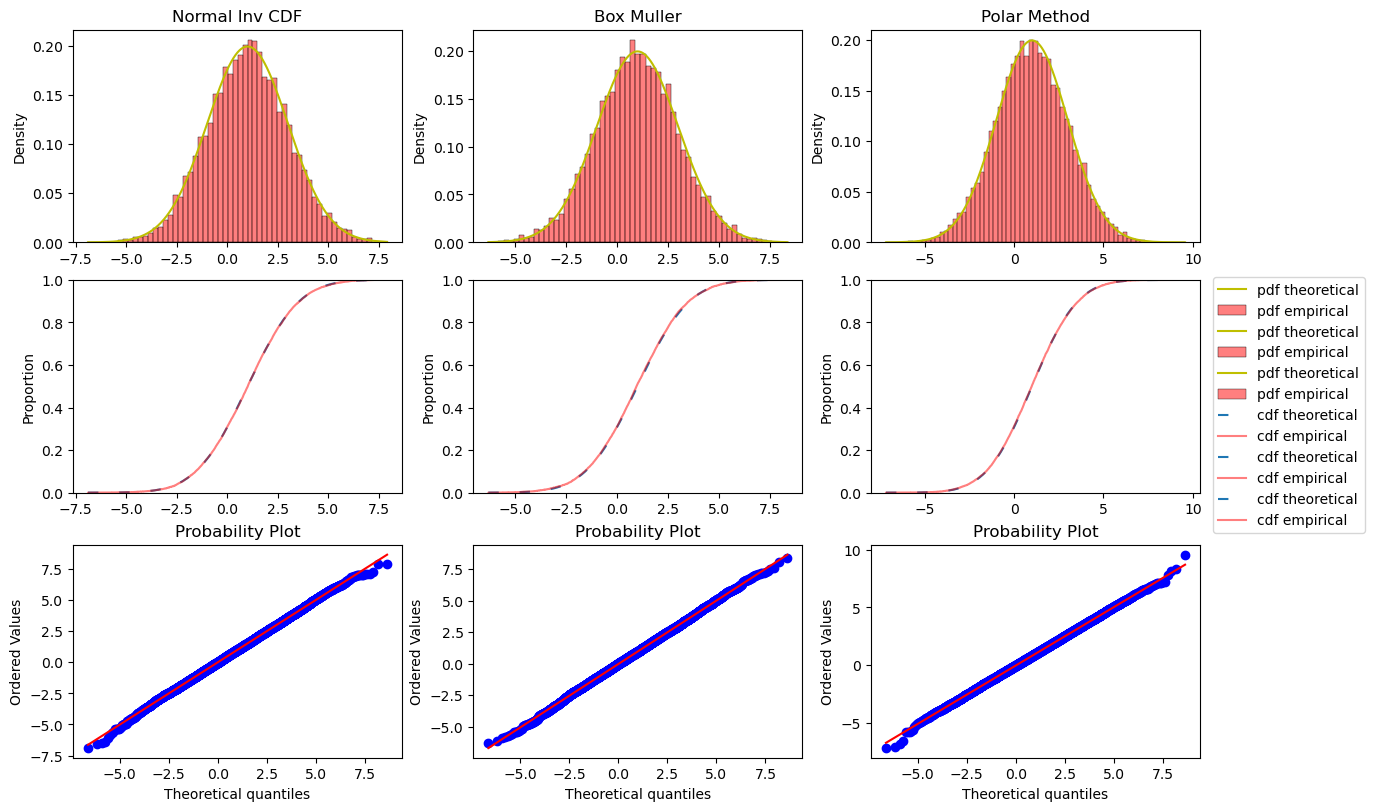

In [6]:
mu, sigma, n = 1, 2, 10000
X = np.zeros(shape=(3, n))
X[0, :] = norm_inv_cdf(n, mu, sigma)
X[1, :] = box_muller(n, mu, sigma)
X[2, :] = polar_method(n, mu, sigma)
print('----------------------------------- NORMAL INV CDF -----------------------------------')
print('Expected value empirical:', np.average(X[0]), 'Expected value Theoretical:', mu)
print('Variance empirical:', np.var(X[0]), 'Variance Theoretical:', sigma**2)
print('----------------------------------- BOX MULLER -----------------------------------')
print('Expected value empirical:', np.average(X[1]), 'Expected value Theoretical:', mu)
print('Variance empirical:', np.var(X[1]), 'Variance Theoretical:', sigma**2)
print('----------------------------------- POLAR METHOD -----------------------------------')
print('Expected value empirical:', np.average(X[2]), 'Expected value Theoretical:', mu)
print('Variance empirical:', np.var(X[2]), 'Variance Theoretical:', sigma**2)
fig, axes = plt.subplots(3, 3, layout="constrained")
val1 = np.unique(X[0, :])
val2 = np.unique(X[1, :])
val3 = np.unique(X[2, :])
axes[0, 0].plot(
    val1,
    stats.norm.pdf(val1, loc=1, scale=2),
    c="y",
    label="pdf theoretical",
)
sns.histplot(
    X[0, :], stat="density", ax=axes[0, 0], color="red", alpha=0.5, label="pdf empirical"
)
axes[1, 0].plot(
    val1,
    stats.norm.cdf(val1, loc=1, scale=2),
    label="cdf theoretical",
    linestyle=(0, (5, 10)),
)
sns.ecdfplot(X[0, :], label="cdf empirical", color="red", alpha=0.5, ax=axes[1, 0])
stats.probplot(X[0, :], dist="norm", sparams=(1, 2), plot=axes[2, 0])
axes[0, 0].set_title("Normal Inv CDF")
axes[0, 1].plot(
    val2,
    stats.norm.pdf(val2, loc=1, scale=2),
    c="y",
    label="pdf theoretical",
)
sns.histplot(
    X[1, :], stat="density", ax=axes[0, 1], color="red", alpha=0.5, label="pdf empirical"
)
axes[1, 1].plot(
    val2,
    stats.norm.cdf(val2, loc=1, scale=2),
    label="cdf theoretical",
    linestyle=(0, (5, 10)),
)
sns.ecdfplot(X[1, :], label="cdf empirical", color="red", alpha=0.5, ax=axes[1, 1])
stats.probplot(X[1, :], dist="norm", sparams=(1, 2), plot=axes[2, 1])
axes[0, 1].set_title("Box Muller")
axes[0, 2].plot(
    val3,
    stats.norm.pdf(val3, loc=1, scale=2),
    c="y",
    label="pdf theoretical",
)
sns.histplot(
    X[2, :], stat="density", ax=axes[0, 2], color="red", alpha=0.5, label="pdf empirical"
)
axes[1, 2].plot(
    val3,
    stats.norm.cdf(val3, loc=1, scale=2),
    label="cdf theoretical",
    linestyle=(0, (5, 10)),
)
sns.ecdfplot(X[2, :], label="cdf empirical", color="red", alpha=0.5, ax=axes[1, 2])
stats.probplot(X[2, :], dist="norm", sparams=(1, 2), plot=axes[2, 2])
axes[0, 2].set_title("Polar Method")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Tak wykonane wykresy widoczne powyżej potwierdzają poprawność działania metod. Wynika to z nałożenia się wartości oczewkiwanych z tymi generowanymi. Oczywiście widoczne są delikatne odchylenia jednak są one nieznaczne. 

## Dodatkowe metody generacji
W celu wykonania drugiej części polecenia ziamplementowane zostaną dwie dodatkowe metody generowania rozkładu normalnego. Jako pierwsza zostanie rozpatrzona metoda tuzina.

### Metoda tuzina
Chcąc przybliżyć działanie omawianej metody warto powiedzieć, że polega ona na generowaniu 12 realizacji zmiennych losowych z rozkładu $U(0,1)$, dodaniu ich do siebie i na końcu odjęciu liczby 6. Uzyskana w ten sposób liczba jest w przybliżeniu realizacją zmiennej losowej z rozkładu $N(0,1)$. Działając według wymienionych kroków został zaimplemntowany poniżej przedstawiony kod.  

In [7]:
def tuzin(size, mu=0, sigma=1):
    """
    Generuje n liczb z rozkładu normalnego o parametrach mu i sigma za pomocą metody tuzina

    :param size: (int) liczba liczb do wygenerowania
    :param mu: (float) wartość oczekiwana
    :param sigma: (float) odchylenie standardowe
    :return: (np.ndarray) n liczb z rozkładu normalnego
    """
    
    Us = np.random.uniform(size=(size, 12))
    return sigma * (np.sum(Us, axis=1) - 6) + mu

Aby zweryfikować działanie tej metody wykonamy teraz taki sam test jak w pierwszej części omawianego zadania.

----------------------------------- METODA TUZINA -----------------------------------
Expected value empirical: 0.9740329686450032 Expected value Theoretical: 1
Variance empirical: 3.962084379536911 Variance Theoretical: 4


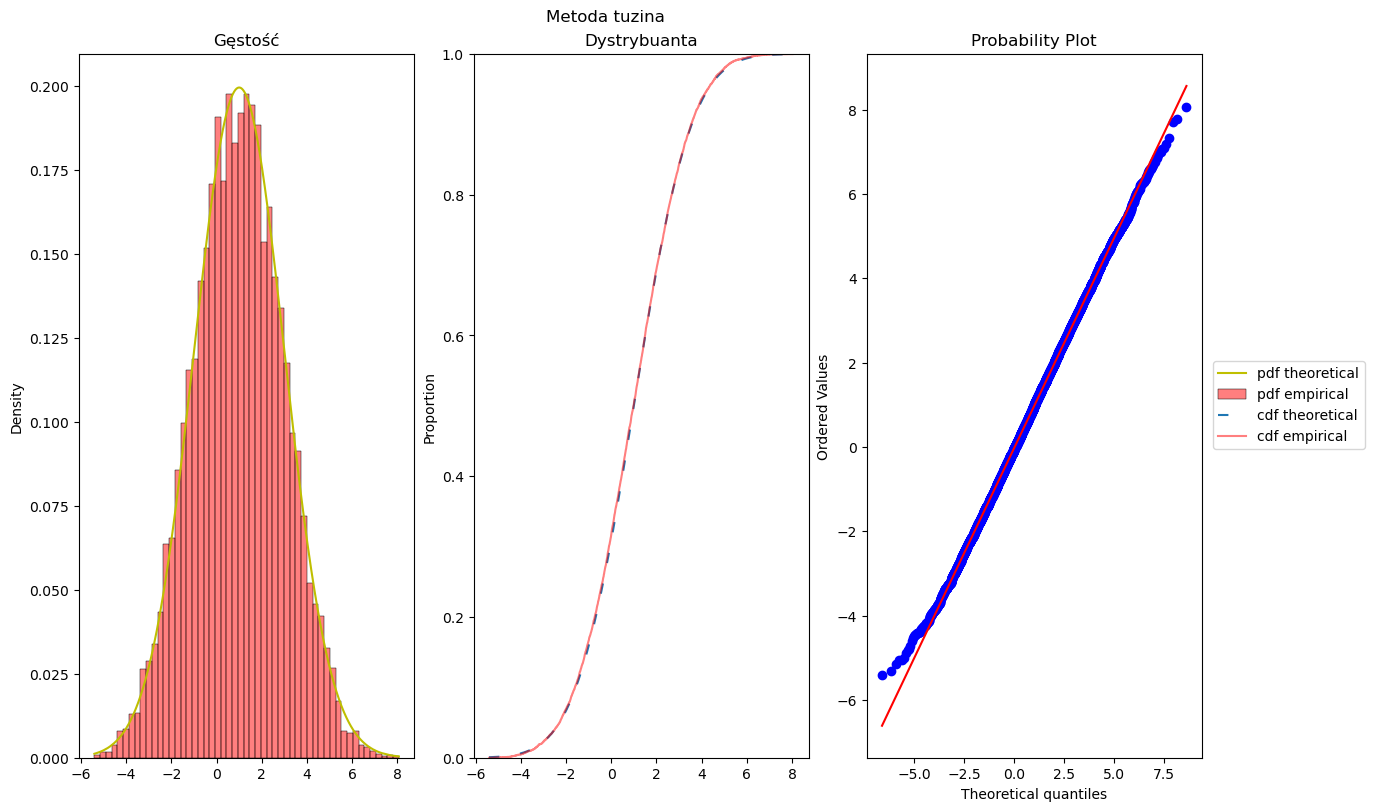

In [8]:
mu, sigma, n = 1, 2, 10000
X = tuzin(n, mu, sigma)
print('----------------------------------- METODA TUZINA -----------------------------------')
print('Expected value empirical:', np.average(X), 'Expected value Theoretical:', mu)
print('Variance empirical:', np.var(X), 'Variance Theoretical:', sigma**2)
fig, axes = plt.subplots(1, 3, layout="constrained")
val = np.unique(X)
axes[0].plot(
    val,
    stats.norm.pdf(val, loc=1, scale=2),
    c="y",
    label="pdf theoretical",
)
sns.histplot(
    X, stat="density", ax=axes[0], color="red", alpha=0.5, label="pdf empirical"
)
axes[1].plot(
    val,
    stats.norm.cdf(val, loc=1, scale=2),
    label="cdf theoretical",
    linestyle=(0, (5, 10)),
)
sns.ecdfplot(X, label="cdf empirical", color="red", alpha=0.5, ax=axes[1])
stats.probplot(X, dist="norm", sparams=(1, 2), plot=axes[2])
fig.suptitle("Metoda tuzina")
axes[0].set_title('Gęstość')
axes[1].set_title('Dystrybuanta')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Wyniki i w tym wypadku pokrywają się z wartosciami teoretycznymi. Świadczy to o poprawności modelu. 

### Metoda zigguratu
Drugą metodą jest metoda zigguratu. Przed implementacją docelowego algorytmu weźmy funkcję $f(x) = \exp(-x^2/2)$, która jest przeskalowaną funkcją gęstości rozkładu $N(0,1)$. W dalszych działaniach będziemy skupiać się tylko na dziedzinie liczb rzeczywistych dodatnich. Następnie zostaną zrealizowane kolejne kroki:
1. Obszar pod wykresem funkcji dzielimy na $n$ prostokątów o równych polach, ustawione jeden nad drugim. 
2. Zapełniamy tablicę $n$ wartościami $x$ i odpowiadającymi ich wartościami $f(x)$ zaczynając od ustalonego $x_1$. 
3. Wygenerowaną tablicę będziemy wykorzystywać każdorazowo przy generacji zmiennych losowych.

In [9]:
f = lambda x: np.exp(-x**2 / 2)
f_inv = lambda y: np.sqrt(-2 * np.log(y))
n = 256
x1 = 3.6541528853610088
y1 = f(x1)
Table = np.zeros(shape=(n, 2))
Table[0, 0] = x1
Table[0, 1] = y1
tail_area = integrate.quad(f, x1, np.inf)[0]
A = x1 * y1 + tail_area
for i in range(1, n-1):
    Table[i, 1] = Table[i-1, 1] + A / Table[i-1, 0]
    Table[i, 0] = f_inv(Table[i, 1])
Table[n-1, 0] = 0
Table[n-1, 1] = 1

Po tak poczynionych krokach wstępnych w docelowym algorytmie wygenerujemy kandydatów na $x$ z różnych warstw prosotkątów. Jeśli $x$ jest większy od $x_1$ stosujemy alternatywny algorytm. Jeśli jest większy, przy użyciu wygenerowanej tablicy sprawdzamy czy znajduje się on poniżej krzywej. Żeby nie generować tylko zmiennych losowych dodatnich, 50% z nich będzie ujemna, dzięki wybraniu $U_0$ z rozkładu $U(-1,1)$. 

In [10]:
def ziggurat(size=1, mu=0, sigma=1, counter=False):
    """
    Generuje n liczb z rozkładu normalnego o parametrach mu i sigma za pomocą metody zigguratu

    :param size: (int) liczba liczb do wygenerowania
    :param mu: (float) wartość oczekiwana
    :param sigma: (float) odchylenie standardowe
    :param counter: (bool) czy zwracać liczbę razy kiedy trzeba obliczyć eksponentę
    :return: (np.ndarray) n liczb z rozkładu normalnego
    """
    
    c = 0
    Xs = np.zeros(size)
    for i in range(size):
        while True:
            indx = int(np.floor(256 * np.random.uniform() - 1))
            U0 = 2 * np.random.uniform() - 1
            if i == -1:
                x = U0 * A / Table[0, 1]
            else:
                x = U0 * Table[indx, 0]
            if np.abs(x) < Table[indx+1, 0]:
                Xs[i] = x
                break
            if indx == -1:  # fallback
                while True:
                    x = -np.log(np.random.uniform()) / Table[0, 0]
                    y = -np.log(np.random.uniform())
                    if 2 * y > x**2:
                        Xs[i] = x + Table[0, 0]
                        break
                break
            else:
                c += 1
                y = Table[indx, 1] + np.random.uniform() * (Table[indx+1, 1] - Table[indx, 1])
                if y < f(x):
                    Xs[i] = x
                    break
    if counter:
        return c
    return Xs * sigma + mu

----------------------------------- METODA ZIGGURATU -----------------------------------
Expected value empirical: 0.9980734696457785 Expected value Theoretical: 1
Variance empirical: 4.0089146189248135 Variance Theoretical: 4


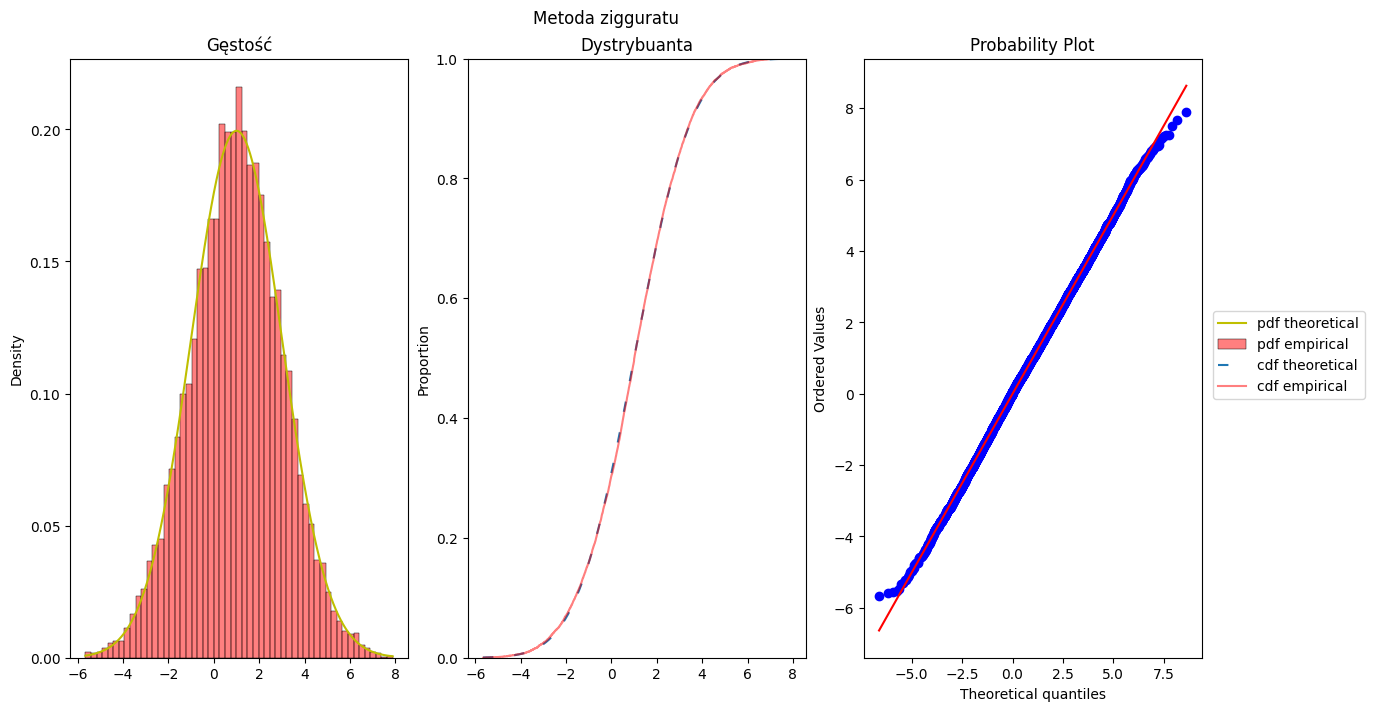

In [122]:
mu, sigma, n = 1, 2, 10000
X = ziggurat(n, mu, sigma)
print('----------------------------------- METODA ZIGGURATU -----------------------------------')
print('Expected value empirical:', np.average(X), 'Expected value Theoretical:', mu)
print('Variance empirical:', np.var(X), 'Variance Theoretical:', sigma**2)
fig, axes = plt.subplots(1, 3, layout="constrained")
val = np.unique(X)
axes[0].plot(
    val,
    stats.norm.pdf(val, loc=1, scale=2),
    c="y",
    label="pdf theoretical",
)
sns.histplot(
    X, stat="density", ax=axes[0], color="red", alpha=0.5, label="pdf empirical"
)
axes[1].plot(
    val,
    stats.norm.cdf(val, loc=1, scale=2),
    label="cdf theoretical",
    linestyle=(0, (5, 10)),
)
sns.ecdfplot(X, label="cdf empirical", color="red", alpha=0.5, ax=axes[1])
stats.probplot(X, dist="norm", sparams=(1, 2), plot=axes[2])
fig.suptitle("Metoda zigguratu")
axes[0].set_title('Gęstość')
axes[1].set_title('Dystrybuanta')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

W ostatniej metodzie analogicznie jak w poprzednich wyniki zostały zweryfikowane za pomocą zestawień wartości teoretycznych z wygenerowanymi. Również w tym przypadku wartości się pokryły.

### Test ilości razy obliczania funkcji wykładniczej
W algorytmie, funkcję wykładniczą obliczamy tylko w przypadku gdy wartość bezwzględna kandydata $x$ dla wylosowanego indeksu $i$ jest większa od $x_{i+1}$, czyli $x$ nie mieści się w wylosowanym prostokącie. W tym przypadku sprawdzany jest warunek $y < f(x)$. Sprawdzimy teraz ile średnio razy mamy z nim do czynienia dla próbek rozmiaru $n=1000$.

/Users/tomasz/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Liczba przypadków na 1000 generacji')

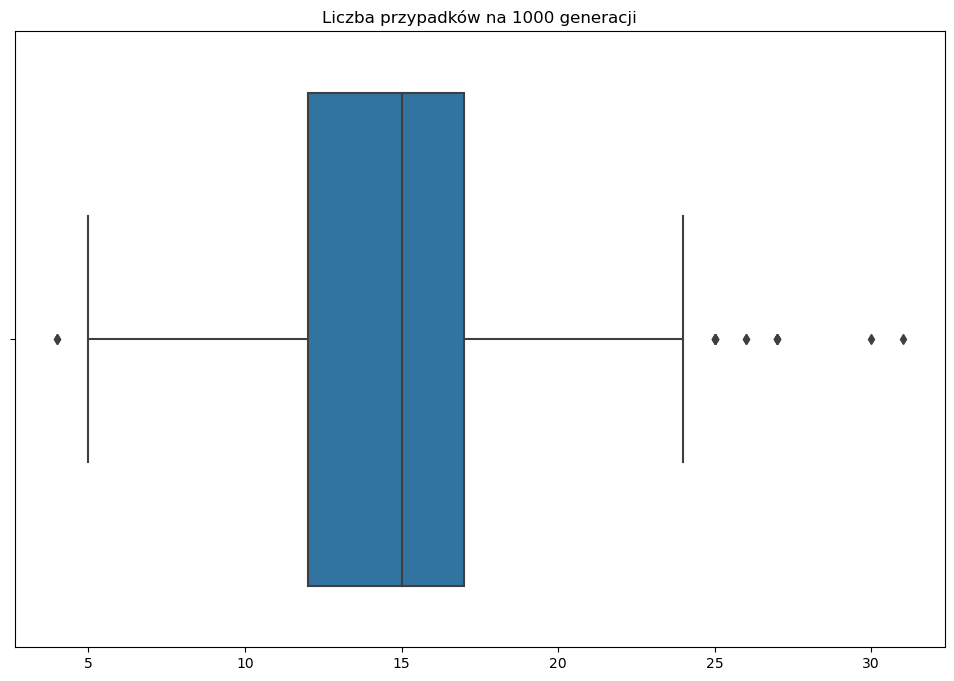

In [11]:
counts = np.zeros(1000)
for i in range(1000):
    counts[i] = ziggurat(1000, counter=True)
fig, ax = plt.subplots()
sns.boxplot(counts, ax=ax)
ax.set_title('Liczba przypadków na 1000 generacji')

Jak widać na wykresie pudełkowym powyżej, przy generacji 1000 zmiennych losowych, średnio 15 razy algorytm wpada w przypadek, w którym trzeba obliczyć eskponentę. Jednak w większości przypadków wartość ta nie będzie przekraczać 25.

### Porównanie efektywności algorytmów
#### Czas wykonania algorytmu w zależności od wielkości próby

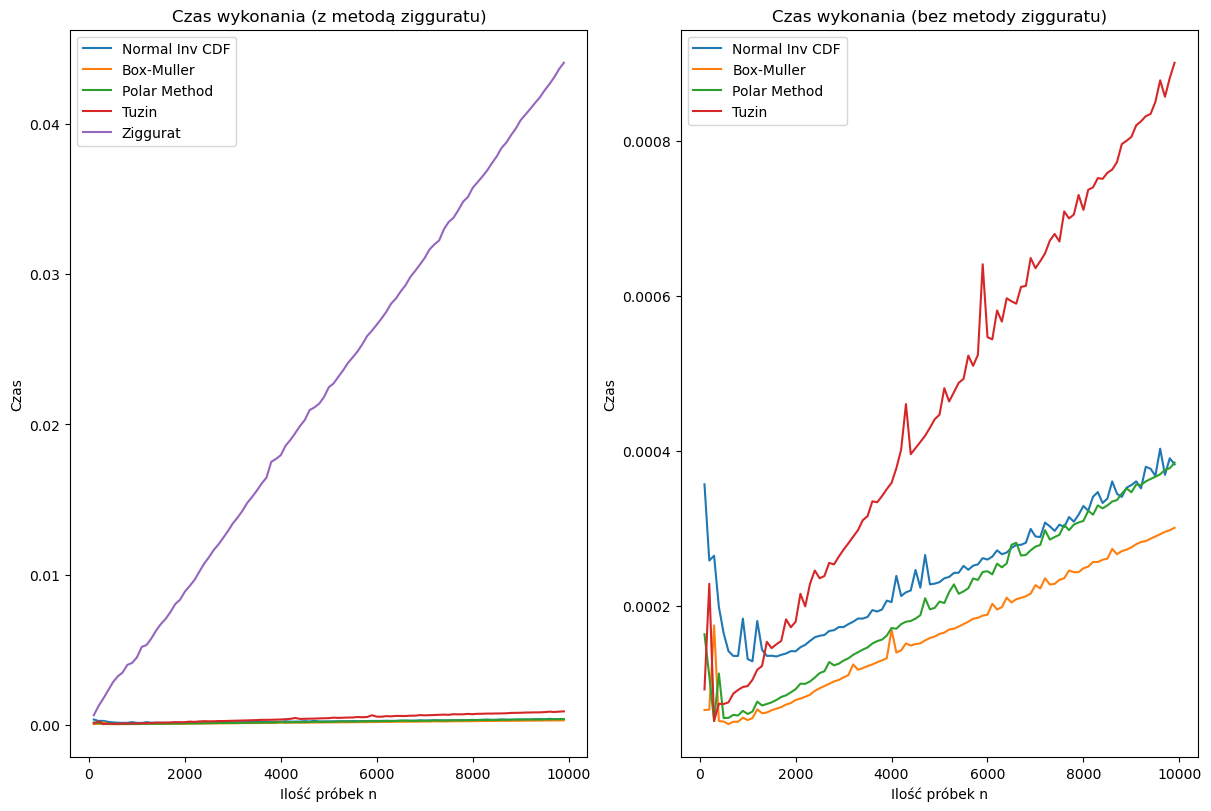

In [12]:
import time

ns = np.arange(100, 10000, 100)
times = np.zeros(shape=(np.size(ns), 5))
for i in range(len(ns)):
    start = time.time()
    norm_inv_cdf(ns[i])
    times[i, 0] = time.time() - start
    start = time.time()
    box_muller(ns[i])
    times[i, 1] = time.time() - start
    start = time.time()
    polar_method(ns[i])
    times[i, 2] = time.time() - start
    start = time.time()
    tuzin(ns[i])
    times[i, 3] = time.time() - start
    start = time.time()
    ziggurat(ns[i])
    times[i, 4] = time.time() - start

fig, axes = plt.subplots(ncols=2, layout="constrained")
axes[0].plot(ns, times[:, 0], label="Normal Inv CDF")
axes[0].plot(ns, times[:, 1], label="Box-Muller")
axes[0].plot(ns, times[:, 2], label="Polar Method")
axes[0].plot(ns, times[:, 3], label="Tuzin")
axes[0].plot(ns, times[:, 4], label="Ziggurat")
axes[0].set_title("Czas wykonania (z metodą zigguratu)")
axes[0].set_xlabel("Ilość próbek n")
axes[0].set_ylabel("Czas")
axes[0].legend()
axes[1].plot(ns, times[:, 0], label="Normal Inv CDF")
axes[1].plot(ns, times[:, 1], label="Box-Muller")
axes[1].plot(ns, times[:, 2], label="Polar Method")
axes[1].plot(ns, times[:, 3], label="Tuzin")
axes[1].set_title("Czas wykonania (bez metody zigguratu)")
axes[1].set_xlabel("Ilość próbek n")
axes[1].set_ylabel("Czas")
axes[1].legend()
plt.show()

Czas wykonia algorytmu wykorzystującego metodę zigguratu jest znacząco dłuższy od czasów dla pozostałych algorytmów. Jest to spowodoawne faktem, że jako jedyny nie został zaimplementowany wektorowo. Metody biegunowa, odwrotnej dystrybuanty oraz Boxa-Muellera są najszybsze. Natomiast czas generowania metodą tuzina lekko odstaje od tych trzech.

### Dokładność symulacji - test Kolomogorova-Smirnova

In [125]:
ks_statistic_method1, ks_pvalue_method1 = stats.kstest(norm_inv_cdf, 'norm')
ks_statistic_method2, ks_pvalue_method2 = stats.kstest(box_muller, 'norm')
ks_statistic_method3, ks_pvalue_method3 = stats.kstest(polar_method, 'norm')
ks_statistic_method4, ks_pvalue_method4 = stats.kstest(tuzin, 'norm')
ks_statistic_method5, ks_pvalue_method5 = stats.kstest(ziggurat, 'norm')

print(f"Normal Inv CDF K-S Test: statistic={ks_statistic_method1}, p-value={ks_pvalue_method1}\n")
print(f"Box-Mueller K-S Test: statistic={ks_statistic_method2}, p-value={ks_pvalue_method2}\n")
print(f"Polar Method K-S Test: statistic={ks_statistic_method3}, p-value={ks_pvalue_method3}\n")
print(f"Tuzin K-S Test: statistic={ks_statistic_method4}, p-value={ks_pvalue_method4}\n")
print(f"Ziggurat K-S Test: statistic={ks_statistic_method5}, p-value={ks_pvalue_method5}\n")

Normal Inv CDF K-S Test: statistic=0.0838915309386381, p-value=0.9966939108571323

Box-Mueller K-S Test: statistic=0.11856710907884332, p-value=0.9103370420813638

Polar Method K-S Test: statistic=0.11086809964185487, p-value=0.9439393437100231

Tuzin K-S Test: statistic=0.15662382753575788, p-value=0.6542324867783329

Ziggurat K-S Test: statistic=0.14539349925218215, p-value=0.7388234188636461



Dla domyślnych 20 realizacji zmiennych losowych przeprowadziliśmy test Kolmogorova-Smirnova przy użyciu funkcji $scipy.stats.kstest$. Statysyka testowa dla każdego z generatorów jest rzędu $10^{-1}$. P-wartości również są na podobnym poziomie. Biorąc pod uwagę poziom istotności testu $\alpha = 0.05$, nie mamy przesłanek do odrzucenia hipotezy zerowej ($H_0$ - realizacje pochodzą z rozkładu normalnego) dla żadnego z generatorów.

## 3: Metody redukcji wariancji

### Cel
Celem zadania jest zbadanie i porównanie metod redukcji wariancji dla estymacji wartości liczby π za pomocą metody zmiennej kontrolnej (Control Variates) oraz metody odbić lustrzanych (Antithetic Variates).

### Rozwiązanie
Na początku chcemy wykonać szacowanie liczby $\pi$ przy użyciu metody Monte Carlo. W związku z tym generujemy $n$  zmiennych losowych z rozkładu  jednostajnego na przedziale [0, 1]. Nastęnie obliczamy średnią wartość funkcji $\frac{1}{1 + x^2}$ dla wszystkich wygenerowanych $Xs$. Przy takim szacowaniu większa liczba $n$ oznacza dokładniejsze oszacowanie.

In [3]:
def monte_carlo(n):
    """
    Szacuje wartość liczby pi za pomocą metody Monte Carlo.

    :param n: (int) liczba losowych próbek do wygenerowania
    :return: (float) oszacowana wartość liczby pi
    """
    Xs = np.random.uniform(size=n)  
    return 4 * np.sum(1 / (1 + Xs ** 2)) / n

In [127]:
ns = [10, 100, 1000, 10000, 100000, 1000000]
for n in ns:
    pi = monte_carlo(n)
    print(pi)

2.988919053255297
3.130780568411291
3.1235093240884355
3.1324839440631056
3.1398723562643562
3.1418804121449893


Ostatni widoczny powyżej wynik najlepiej przybliża wartość liczby $\pi$. Świadczy to o poprawności stwierdzenia dotyczącego wzrostu dokładności wyniku w momencie zwiększenia wartości $n$.

### Metoda zmiennej kontrolnej
Przejdźmy do metody zmiennej kontrolnej. Jest to technika używana w metodach Monte Carlo w celu zmniejszenia wariancji estymatorów oraz poprawy precyzji wyników. Idea tego pomysłu polega na wprowadzeniu dodatkowej zmiennej losowej, której wartość oczekiwana jest znana i zbliżona do wartości oczekiwanej zmiennej, którą chcemy estymować. Poprzez korelację między tymi zmiennymi, można uzyskać dokładniejsze estymacje. Natomiast stała $c$ jest współczynnikiem, który kontroluje wpływ tej zmiennej na estymację.

#### Wyznaczanie stałej "c"
Aby analitycznie wyliczyć współczynnik $c$, musimy znaleźć wartości $\text{Cov}(f(X), g(X))$ oraz $\text{Var}(g(X))$, gdzie $X$ jest zmienną losową o rozkładzie jednostajnym na przedziale $[0, 1]$.

Zdefiniujmy zatem funkcje:
\begin{align*}
f(x) &= \frac{4}{1 + x^2}, \\ g(x) &= x. 
\end{align*}
Teraz obliczmy ich wartości oczekiwane:
\begin{align*}
\mathbb{E}[f(X)] &= \pi \\  \mathbb{E}[g(X)] &= \mathbb{E}[X] = \frac{1}{2}
\end{align*}
Aby wyliczyć wartość kowariancji wykonaliśmy poniższe przekształcenia.
\begin{align*} \text{Cov}(f(X), g(X)) = \mathbb{E}[f(X) \cdot g(X)] - \mathbb{E}[f(X)] \cdot \mathbb{E}[g(X)] = 2 \ln(2) - \frac{\pi}{2}  \end{align*}
Następnie 
\begin{align*} \text{Var}(g(X)) = \mathbb{E}[g(X)^2] - (\mathbb{E}[g(X)])^2 = \frac{1}{12}. \end{align*}

Zatem korzystając z powyższego możemy już wyznaczyć stałą $c$:

\begin{align*} c = -\frac{\text{Cov}(f(X), g(X))}{\text{Var}(g(X))} = -\frac{2 \ln(2) - \frac{\pi}{2}}{\frac{1}{12}} = -12 (2 \ln(2) - \frac{\pi}{2}) = -24 \ln(2) + 6 \pi. \end{align*} 
Na podstawie tak wyznaczonej wartości możemy obliczyć wartość numeryczną zmiennej. 

In [4]:
c_a = -24*np.log(2) + 6*np.pi
print("Stała c wyznaczona analitycznie:", c_a)

Stała c wyznaczona analitycznie: 2.2140235881000727


Jedank w omawianym zadaniu wyestymujemy wartości stałej $c$. W tym celu powtórzymy kroki z rozwiązania analitycznego dla wygenrowanej próbki

In [12]:
n_c = 100
x_c = np.random.uniform(size=n_c)
f_vals = 4 / (1 + x_c**2)
g_vals = x_c
f_mean = np.mean(f_vals)
g_mean = np.mean(g_vals)
cov = np.mean((f_vals - f_mean) * (g_vals - g_mean))
var = np.var(g_vals)
c = -cov / var
print("Stała c wyznaczona symulacyjnie:", c)

Stała c wyznaczona symulacyjnie: 2.2172737734554646


Jak możemy zauważyć, wyniki estymowane oraz teoretyczne przyjmują podobne wartości. 

Aby otrzymać skorygowaną estymatę liczby $\pi$, wykorzystujemy zmienną kontrolną. Takie działanie ma funkcja zaimplementowana poniżej control_variates. Wykorzystuje ona dodatkową funkcje kontrolną (w tym przypadku wybraliśmy g(x) = x), której wartość oczekiwana jest znana i wynosi $\frac{1}{2}$, a także wyliczoną wcześniej wartość $c$ do zmniejszenia wariancji głównej funkcji $f(x)$



In [8]:
def control_variates(n, c):
   """
    Szacuje wartość liczby pi za pomocą metody wariantów kontrolnych (Control Variates).

    :param n: (int) liczba losowych próbek do wygenerowania
    :param c: (float) zmienna kontrolna
    :return: (float) oszacowana wartość liczby pi
   """
   Xs = np.random.uniform(size=n)  # Generowanie n losowych próbek z rozkładu jednostajnego na przedziale [0, 1]
   f = lambda x: 4 / (1 + x ** 2)  # Funkcja f(x) do oszacowania wartości pi
   g = lambda x: x # Dodatkowa funkcja
    
   g_mean = np.mean(g(Xs))  # Średnia wartość g(x)
   f_mean = np.mean(f(Xs))  # Średnia wartość f(x)
    
   return f_mean + c * (g_mean - 0.5)  

### Metoda odbić lustrzanych
Przejdźmy do metody odbić lustrzanych. W tradycyjnej metodzie Monte Carlo estymujemy wartość oczekiwaną funkcji poprzez losowanie niezależnych próbek i uśrednianie ich wartości. Metoda odbić lustrzanych zamiast tego wykorzystuje parę próbek $(Xs[i], 1 - Xs[i])$, które są silnie skorelowane (symetryczne względem 0.5). Dzięki temu, gdy łączymy wartości funkcji obliczone dla $Xs$ i $1 - Xs$, różnice między nimi się wzajemnie kompensują, co zmniejsza całkowitą wariancję estymatora.

In [10]:
def antithetic_variates(n):
    """
    Szacuje wartość liczby pi za pomocą metody wariantów przeciwstawnych (Antithetic Variates).

    :param n: (int) liczba losowych próbek do wygenerowania, powinna być parzysta
    :return: (float) oszacowana wartość liczby pi
    """
    Xs = np.random.uniform(size=n//2)  # Generowanie n/2 losowych próbek z rozkładu jednostajnego na przedziale [0, 1]
    Xs = np.concatenate((Xs, 1 - Xs))  # Dodawanie próbek przeciwstawnych
    return np.mean(4 / (1 + Xs ** 2))  


Wykonamy teraz symulacje dla różnych liczności próbek n, aby porównać ich efektywność i dokładność w estymacji liczby π.

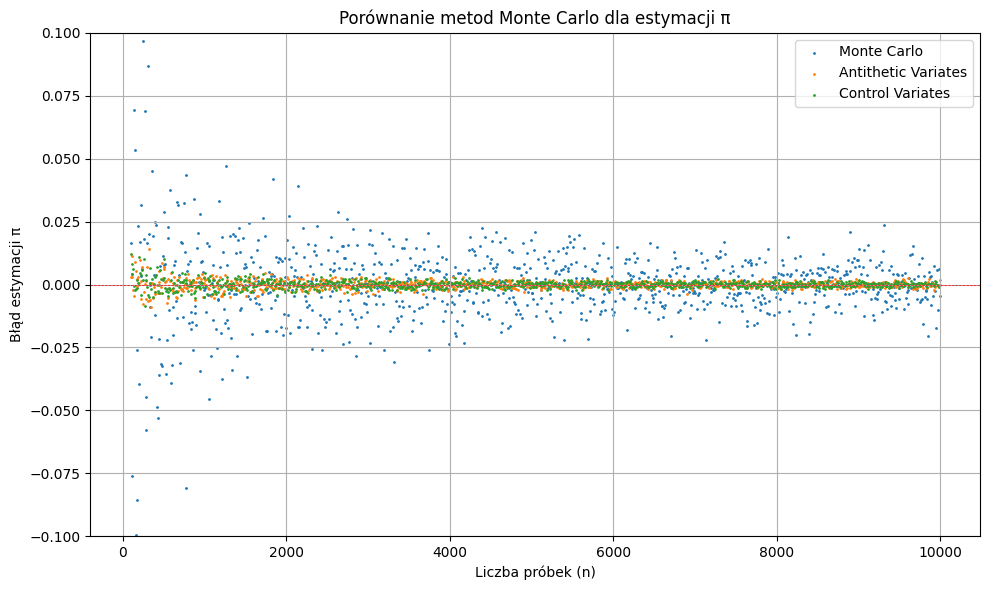

In [11]:
ns = np.arange(100, 10000, 10)
vals = np.zeros(shape=(4,len(ns)))
i = 0
for n in ns:
    vals[0, i] = monte_carlo(n)
    vals[1, i] = antithetic_variates(n)
    vals[2, i] = control_variates(n, c)
    vals[3, i] = control_variates(n, c_a)
    i += 1
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(ns, vals[0, :] - np.pi, label='Monte Carlo', s=1)
ax.scatter(ns, vals[1, :] - np.pi, label='Antithetic Variates', s=1)
ax.scatter(ns, vals[2, :] - np.pi, label='Control Variates', s=1)
# ax.plot(ns, ns*[np.pi])

ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5)  # linia referencyjna dla wartości π
ax.set_xlabel('Liczba próbek (n)')
ax.set_ylabel('Błąd estymacji π')
ax.set_title('Porównanie metod Monte Carlo dla estymacji π')
ax.legend()
ax.set_ylim(-0.1, 0.1)
plt.grid(True)
plt.tight_layout()
plt.show()

Możemy zauważyć, że wraz ze wzrostem $n$ wariancja zmniejsza się dla każdej z omawianych metod. Dodatkowo, wykres potwierdza skuteczność dwóch zaimplementowanych modeli, ponieważ rozproszenie estymowanej wartości $\pi$ jest mniejsze w porównaniu do klasycznej metody Monte Carlo.

### Wykresy skrzypcowe

Funkcja sns.violinplot z biblioteki Seaborn w Pythonie służy do wizualizacji rozkładu danych numerycznych. Jest to rodzaj wykresu skrzypcowego, który pozwala na jednoczesne porównanie rozkładu danych w różnych kategoriach.

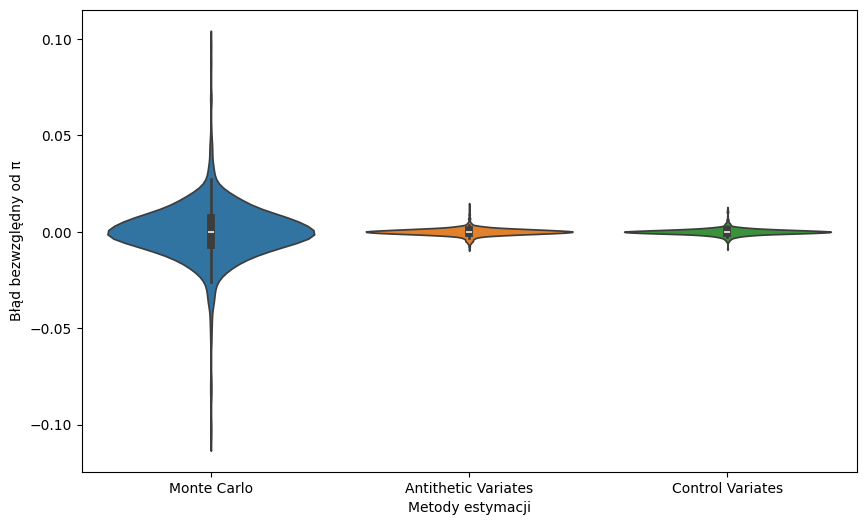

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.violinplot(data=vals[:3].T - np.pi, ax=ax)

ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Monte Carlo', 'Antithetic Variates', 'Control Variates'])

ax.set_ylabel('Błąd bezwzględny od π')
ax.set_xlabel('Metody estymacji')

plt.show()

Na wykresach skrzypcowych możemy zobaczyć rozkład błędów estymacji liczby π dla różnych metod. Skrzydło skrzypca reprezentuje rozkład danych w każdej kategorii, a im szersze skrzydło, tym więcej danych znajduje się w tej części rozkładu. Długość skrzydła wskazuje zakres wartości danych. Metoda Monte Carlo ma szerszy rozkład, co sugeruje większą zmienność wyników. Antithetic Variates i Control Variates mają węższe rozkłady, co wskazuje na większą precyzję tych metod.

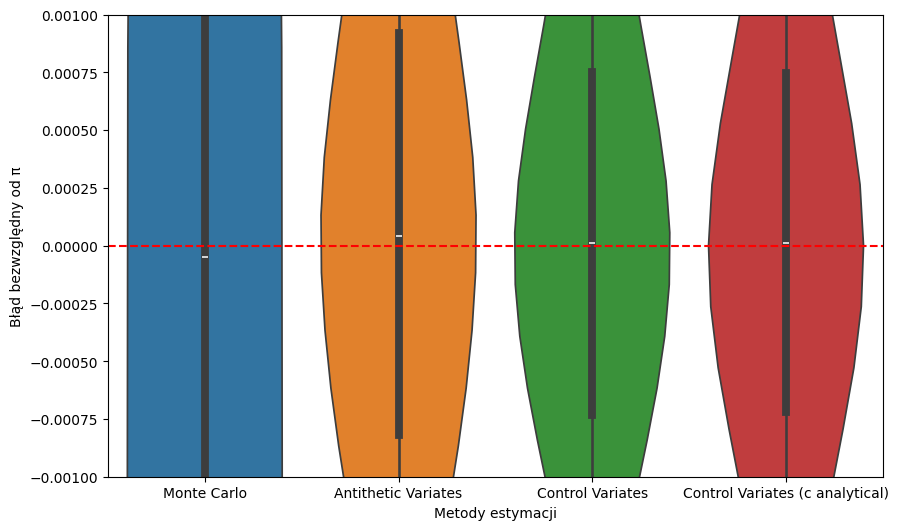

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.violinplot(data=vals.T - np.pi, ax=ax)

ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Monte Carlo', 'Antithetic Variates', 'Control Variates', 'Control Variates (c analytical)'])

ax.set_ylabel('Błąd bezwzględny od π')
ax.set_xlabel('Metody estymacji')
ax.set_ylim(-0.001, 0.001)
ax.axhline(0, color='red', linestyle='--')
plt.show()

Linia środkowa wewnątrz skrzypca to mediana rozkładu danych dla poszczególnej metody. Grube linie wewnątrz skrzypca reprezentują rozstęp międzykwartylowy. W metodzie zmiennych kontrolnych ten rozstęp jest mniejszy, co oznacza, że większa ilość wartości znajduje się bliżej oczekiwanej wartości $\pi$. Oznacza to, że jest ona efektywniejsza od metody odbić lustrzanych. Na wykresie został dodatkowo umieszczony wykres metody zmiennych kontrolnych dla $c$ wyliczonego analitycznie. Możemy zauważyć, że dla takiego $c$ metoda redukcji wariancji jest skuteczniejsza.

## 4: Warunkowa wartość oczekiwana

### Cel
Czwarty rozważany problem jest związany z warunkową wartością oczekiwaną. Rozważymy tu trzy odrębne sytuacje w których celem będzie wyestymowanie wartości oczekiwanych danych zdarzeń oraz zestawienie ich z wartościami teoretycznymi.

### Rozwiązanie
Jako pierwszą rozważymy sytuację która mówi nam, że jeśli $X, Y$ są zmiennymi niezależnymi a $E(Y) = 0$, to dla $Z=XY + sinX$ zachodzi $E(Z|X) = sin X$. 

Aby dokładnie zrozumieć rozwiązanie musimy odpowiedzieć na pytanie w jaki sposób definiujemy wartość oczekiwaną zmiennej losowej. Odpowiadając, jest to średnia, ważona prawdopodobieństwem, wartości zmiennej losowej. Co za tym idzie estymatorem wartości oczekiwanej jest średnia arytmetyczna. Zatem warunkową wartość oczekiwaną możemy estymować poprzez symulowanie $n$ wartości z rozkładu $N \sim (0,1)$, a następnie wyznaczenie wartości zmiennej $Z$ dla kolejnych wartości $X$ oraz średniej arytmetycznej z wyznaczonych wartości $Y$. 

Chcąc wykonać opisane działanie zacznijamy od zdefiniowanych przykładowych parametrów oraz wygenerujmy $n$ zmiennych $X$ oraz $Y$.

In [136]:
n = 1000
X = np.random.normal(0, 1, n)
Y = np.random.normal(0, 1, n)

Następnie zdefiniujmy generowane zmienne losowe $Z$, wartości estymowane $Z$ oraz wartości teoretyczne. Tak obliczone wartości zostaną przedstawione na wykresie w celu wizualizacji. 

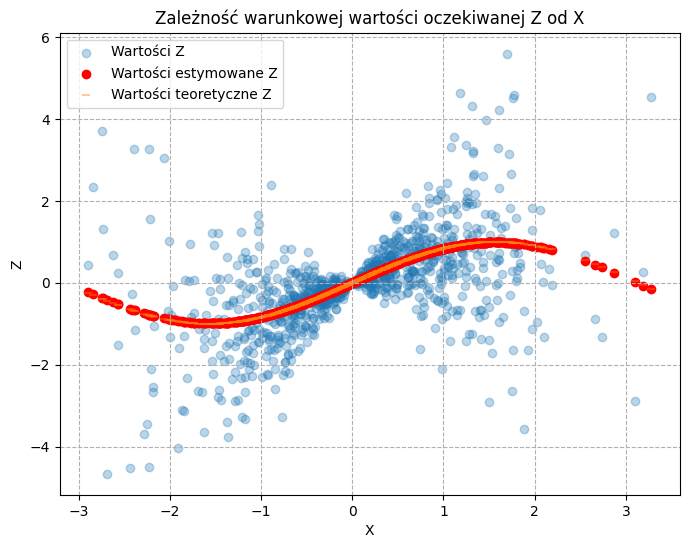

In [137]:
Z = X * Y + np.sin(X)
estymowane_Z = X * np.mean(Y) + np.sin(X)
theo_EZ = np.sin(X)

plt.figure(figsize=(8, 6))
plt.scatter(X, Z, alpha=0.3, label='Wartości Z')
plt.scatter(X, estymowane_Z, color='red', label='Wartości estymowane Z')
plt.scatter(X, theo_EZ, alpha=0.4, marker='_', label='Wartości teoretyczne Z')
plt.xlabel('X')
plt.ylabel('Z')
plt.legend()
plt.grid(linestyle="--")
plt.title('Zależność warunkowej wartości oczekiwanej Z od X')
plt.show()


Jak można zauważyć na grafie wartości estymowane oraz teortyczne się pokrywają, co może świadczyć o poprawności metody. Natomiast błękitne punkty reprezentują zmienne Z wyliczone dla każdej możliwej pary $(X, Y)$. Może to prowadzić do wniosków, że przyjęty i rozważony estymator wartości oczekiwanej (tu średnia arytmetyczna) jest poprawnie zdefiniowaną statystyką.

Kolejną rozważaną sytuacją jest własność mówiąca, że gdy N jest procesem Poissona o intensywnosci $\lambda$, to dla T ≥ t ≥ 0 zachodzi $E(Nt|NT ) = tNT/T$ . Oznacza to, że np. zakładając przybywanie klientów do sklepu zgodnie z procesem Poissona i mając dane na temat dotychczasowej ilości klientów w sklepie w chwili $T$ (czyli $NT$ ), to najlepszym przybliżeniem dotychczasowej chwili
klientów w chwili $t < T$ równej $Nt$ jest $tNT /T$.

By zweryfikować te własność znowu posłużymy się estymatorem jakim jest średnia arytmetyczna. Jednak jako że mamy do czynienia z procesem Poissona będzie konieczne wygenerowanie $n$ trajektorii a następnie obliczenie średniej z osiągniętych wartości w każdym punkcie czasu $t<T$. Zacznijmy od napisania funkcji do generowania trajektorii z rozkładu Poissona.

In [138]:
def poisson_traj(T: float, num_trajectories: int, lam: float) -> typing.Tuple[np.ndarray, np.ndarray]:
    """
    Generuje trajektorie procesu Poissona.

    Args:
        T (float): Całkowity czas trwania symulacji.
        num_trajectories (int): Liczba trajektorii do wygenerowania.
        lam (float): Intensywność procesu Poissona.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Zwraca krotkę zawierającą tablicę wartości czasu (t_values) 
        oraz dwuwymiarową tablicę trajektorii (trajectories).
    """
    dt = 0.01
    t_values = np.arange(0, T + dt, dt)
    num_steps = len(t_values)
    
    trajectories = np.zeros((num_trajectories, num_steps))
    
    for i in range(num_trajectories):
        for t in range(1, num_steps):
            trajectories[i, t] = trajectories[i, t-1] + np.random.poisson(lam * dt)  
    return t_values, trajectories

Teraz by z łatwością wyliczyć średnią intensywność trajektorii procesu Poissona dla zadanego czasu T zadeklarujemy odpowiednią funkcje. Średnia intensywność będzie wyliczana jako średnia liczba zdarzeń w czasie dla wszystkich trajektorii.

In [139]:
def calculate_average_intensity(trajectories: np.ndarray, T: float) -> typing.Tuple[np.ndarray, np.ndarray]:
    """
    Oblicza średnią intensywność trajektorii procesu Poissona.

    Args:
        trajectories (np.ndarray): Dwuwymiarowa tablica zawierająca trajektorie procesu Poissona.
        T (float): Całkowity czas trwania symulacji.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Zwraca krotkę zawierającą tablicę wartości czasu (t_values) 
        oraz średnią intensywność (average_Nt_over_T) dla każdej chwili czasu.
    """
    num_trajectories, num_steps = trajectories.shape
    t_values = np.linspace(0, T, num_steps)
    average_Nt = np.mean(trajectories, axis=0)
    return t_values, average_Nt

Chcąc zweryfikować poprawność metody wywołajmy funkcje dla przykładowych parametrów $T=1, n=1000, \lambda = 10$ oraz przedstawmy wyniki na wykresie.

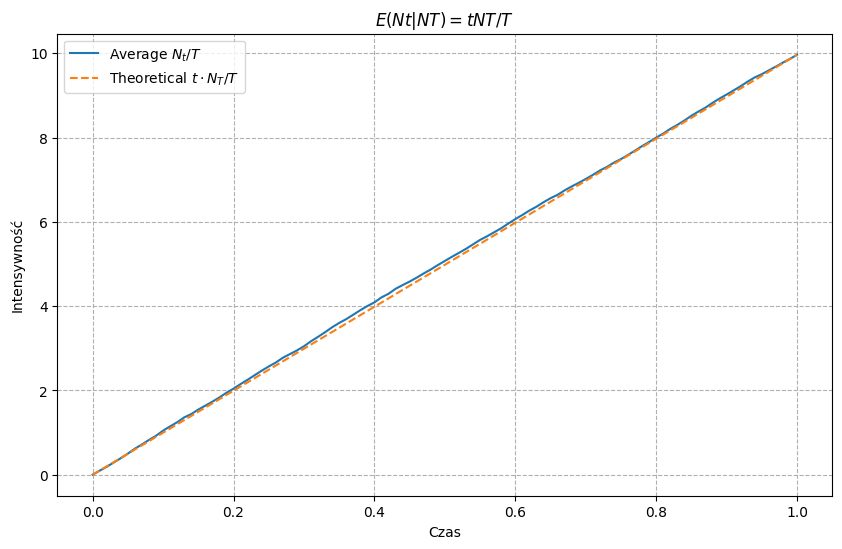

In [140]:
T = 1
num_trajectories = 1000
lam = 10
t_values, trajectories = poisson_traj(T, num_trajectories, lam)
t_values, average_intensity = calculate_average_intensity(trajectories, T)

#Obliczenie wartości teoretycznych
N_T = np.mean(trajectories[:, -1])
theo = t_values * N_T / T

plt.figure(figsize=(10, 6))
plt.plot(t_values, average_intensity, label='Average $N_t/T$')
plt.plot(t_values, theo, label='Theoretical $t \cdot N_T / T$', linestyle='--')
plt.xlabel('Czas')
plt.ylabel('Intensywność')
plt.title('$E(Nt|NT ) = tNT/T$')
plt.legend()
plt.grid(linestyle="--")
plt.show()

Powyższy wykres potwierdza poprawność metody. Wartości estymowane pokrywają się z teoretycznymi. Widoczne są jedynie niewielkie odchylenia które mogą wynikać z pseudolosowości generowanych trajektorii.

Ostatnim problemem dotyczącym warunkowej wartości oczekiwanej jest stwierdzenie poprawności następującego wyrażenia. Gdy N jest procesem Poissona o intensywności $\lambda$, to dla $t ≥ s ≥ 0$ zachodzi $E(Nt|Fs) = Ns + \lambda(t − s)$, gdzie
$Fs$ to filtracja naturalna procesu $Ns$. Oznacza to, że np. zakładając przybywanie klientów do sklepu zgodnie z
procesem Poissona i mając dane na temat dotychczasowej ilości klientów w sklepie w każdej chwili ω spełniającej
$0 ≤ \omega ≤ s$ (czyli $Fs$), to najlepszym przybliżeniem dotychczasowej chwili klientów w chwili $t ≥$ s jest $Ns+\lambda(t−s)$.

W celu weryfikacji tego wygenerujemy trajektorie korzystając z wcześniej zaimplementowanej funkcji poisson_traj. A następnie od miejsca $t=s$ wygenerujemy kolejne trajektorie i z nich wyliczymy wartość średnią w odpowiednich miejscach czasowych. W tym rozwiązaniu korzystamy z własności Markowa która mówi, że przyszłe zmiany procesu są niezależne od przeszłości, o ile znamy obecny stan.

Wywołując funkcję przyjmiemy wartości parametrów $s=1, \lambda=1, T=20$ oraz $n=1000$.

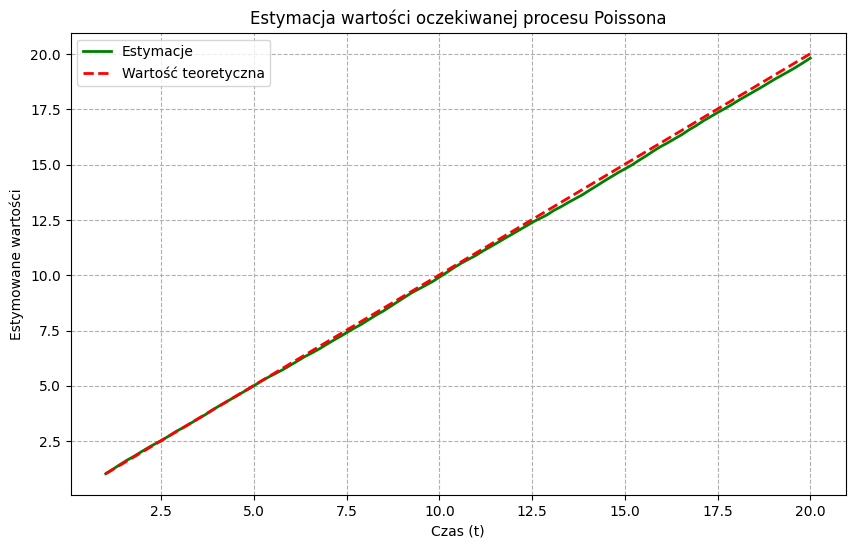

In [141]:
s = 1
lam = 1
T = 20
num_simulations = 1000

t_values, trajectories = poisson_traj(T, num_simulations, lam)

dt = 0.01
idx_s = int(s / dt)
Ns = trajectories[:, idx_s].mean()

times_for_estimation = np.linspace(s, T, 100)
estimations = []

for t in times_for_estimation:
    idx_t = int(t / dt)
    Nt = trajectories[:, idx_t]
    estimation = Nt.mean()
    estimations.append(estimation)

plt.figure(figsize=(10, 6))
plt.plot(times_for_estimation, estimations, label='Estymacje', color='g', linewidth=2)
plt.plot(times_for_estimation, Ns + lam * (times_for_estimation - s), label='Wartość teoretyczna', color='r', linestyle='--', linewidth=2)
plt.xlabel('Czas (t)')
plt.ylabel('Estymowane wartości')
plt.title('Estymacja wartości oczekiwanej procesu Poissona')
plt.legend()
plt.grid(linestyle="--")
plt.show()

Korzystanie z własności Marowa w rzeczywisty sposób odzwierciedla wartości teoretyczne. Potwierdza to poprawność użytej metody generacji. 

## 5: Czas ruiny

### Cel
Celem zadania jest analiza i szacowanie prawdopodobieństwa ruiny w ubezpieczeniowym modelu ryzyka, bazującym na procesie Poissona. Model ten jest używany do określania prawdopodobieństwa, że kapitał ubezpieczyciela spadnie poniżej zera w danym okresie. Przeprowadzimy symulacje stochastyczne oraz porównamy wyniki z teoretycznymi wartościami uzyskanymi za pomocą wzoru Pollaczka-Chinczyna:
\begin{equation*}
\psi(u, c)=\frac{\eta \lambda}{c}e^{-(\frac{1}{\eta}-\frac{\lambda}{c})u}
\end{equation*}
oraz dla funkcji odrwotnej.

### Rozwiązanie
Zacznijmy od zdefiniowania funkcji potrzebnych do wykonania zadania. Zostaną one kolejno omówione poniżej.

In [2]:
def estimate_psi(u, c, lamb, eta, T, N):
    """
    Szacuje wartość psi za pomocą symulacji stochastycznych.

    :param u: (float) początkowy kapitał
    :param c: (float) stała stawka wpłat
    :param lamb: (float) intensywność procesu Poissona
    :param eta: (float) parametr skali rozkładu wykładniczego
    :param T: (float) czas trwania
    :param N: (int) liczba symulacji
    :return: (float) oszacowana wartość psi, czyli prawdopodobieństwo ruiny
    """
    r = 0
    for _ in range(N):
        n = stats.poisson.rvs(mu=lamb * T)  # Losowanie liczby zdarzeń z rozkładu Poissona
        if n == 0:
            continue
        Us = T * np.random.uniform(size=n)  # Generowanie losowych czasów zdarzeń
        Us = np.sort(Us)  # Sortowanie czasów zdarzeń
        X = np.random.exponential(scale=eta, size=n)  # Generowanie strat z rozkładu wykładniczego
        R_t = u + c * Us - np.cumsum(X)  # Obliczanie kapitału w kolejnych momentach czasu
        if np.any(R_t < 0):  # Sprawdzanie, czy kapitał kiedykolwiek spadł poniżej zera
            r += 1
    return r / N  # Oszacowanie prawdopodobieństwa ruiny

Funkcja estimate_psi szacuje prawdopodobieństwo ruiny przy użyciu symulacji stochastycznych. Dla każdej symulacji losujemy liczbę zdarzeń z procesu Poissona, generujemy losowe czasy zdarzeń oraz losowe wartości strat. Następnie obliczamy kapitał w kolejnych momentach czasu i sprawdzamy, czy kiedykolwiek spadł poniżej zera. Wynik to stosunek liczby przypadków, w których kapitał spadł poniżej zera, do całkowitej liczby symulacji.

In [8]:
def find_c(u, psi, lambd, eta, T, num_simulations=1000, tol=1e-6, max_iter=100):
    """
    Znajduje wartość c, która spełnia dane prawdopodobieństwo psi za pomocą metody podziału i poszukiwania (divide and conquer).

    :param u: (float) początkowy kapitał
    :param psi: (float) docelowe prawdopodobieństwo ruiny
    :param lambd: (float) intensywność procesu Poissona
    :param eta: (float) parametr skali rozkładu wykładniczego
    :param T: (float) czas trwania
    :param num_simulations: (int) liczba symulacji dla każdej iteracji (domyślnie 1000)
    :param tol: (float) tolerancja błędu przy porównywaniu psi_est z psi (domyślnie 1e-2)
    :param max_iter: (int) maksymalna liczba iteracji (domyślnie 100)
    :return: (float) oszacowana wartość c, która spełnia dane prawdopodobieństwo psi
    """
    low, high = 0, 5  # Początkowy zakres dla c
    for _ in range(max_iter):
        # print(_)
        mid = (low + high) / 2  # Obliczanie środka zakresu
        psi_est = estimate_psi(u, mid, lambd, eta, T, num_simulations)  # Szacowanie psi dla bieżącego c
        if abs(psi_est - psi) < tol:  # Sprawdzanie, czy różnica między psi_est a psi jest w tolerancji
            return mid
        elif psi_est < psi:  # Jeśli oszacowane psi jest mniejsze niż docelowe psi, zmniejszamy zakres
            high = mid
        else:  # Jeśli oszacowane psi jest większe niż docelowe psi, zwiększamy zakres
            low = mid
    return mid  # Zwracanie oszacowanej wartości c

Funkcja find_c stosuje metodę dziel i zwycięzaj (divide and conquer), aby znaleźć wartość stawki wpłat 
𝑐, która spełnia określone prawdopodobieństwo ruiny 
𝜓. Poprzez iteracyjne zmniejszanie zakresu poszukiwań, funkcja dąży do znalezienia wartości 
𝑐
dla zadandej tolerancji błędu.

In [ ]:
def pollaczek_chinczyn_psi(u, c, lambd, eta):
    """
    Oblicza prawdopodobieństwo ruiny w czasie nieskończonym za pomocą wzoru Pollaczka-Chinczyna.

    :param u: (float) początkowy kapitał
    :param c: (float) stała stawka wpłat
    :param lambd: (float) intensywność procesu Poissona
    :param eta: (float) parametr skali rozkładu wykładniczego
    :return: (float) prawdopodobieństwo ruiny w czasie nieskończonym ψ(u, c)
    """
    if c <= lambd * eta:
        return 1
    return (lambd * eta / c) * np.exp(-(1/eta - lambd/c) * u)

Funkcja pollaczek_chinczyn_psi oblicza teoretyczne prawdopodobieństwo ruiny w czasie nieskończonym za pomocą wzoru Pollaczka-Chinczyna. Jest to analityczna metoda umożliwiająca dokładne obliczenie prawdopodobieństwa ruiny, w zależności od początkowego kapitału 
𝑢, stałej stawki wpłat 
𝑐, intensywności procesu Poissona 
𝜆 oraz parametru skali rozkładu wykładniczego 
𝜂.

In [4]:
def inverse_c(u, psi, lambd, eta):
    """
    Znajduje wartość stałej stawki wpłat (c) dla danego początkowego kapitału (u) oraz prawdopodobieństwa ruiny (psi) 
    za pomocą funkcji odwrotnej wyznaczonej wzorem z funkcją W Lamberta.

    :param u: (float) początkowy kapitał
    :param psi: (float) docelowe prawdopodobieństwo ruiny
    :param lambd: (float) intensywność procesu Poissona
    :param eta: (float) parametr skali rozkładu wykładniczego
    :return: (float) wartość stałej stawki wpłat (c) spełniająca dane prawdopodobieństwo ruiny
    """
    return (lambd * u) / np.real(lambertw((u * psi * np.exp(u / eta)) / eta))

Funkcja inverse_c oblicza wartość stałej stawki wpłat 
𝑐 dla danego początkowego kapitału 
𝑢 i prawdopodobieństwa ruiny 
𝜓, używając funkcji odwrotnej. Pozwala to na analityczne wyznaczenie wymaganej stawki wpłat, aby osiągnąć zadane prawdopodobieństwo ruiny.
Do implementacji wzoru posłużyliśmy się funkcją W Lamberta uzyskaną za pomocą biblioteki scipy.special. Aby uzyskać wartość $W_{0}$ z tej funkcji, posługujemy się funkcją lambertw(z), której argumentem jest nasze wyrażenie. Funkcja 
przyjmuje wartości rzeczywiste dla argumentów spełniających warunek x >= -1/e. Dla argumentów spoza tego zakresu, funkcja może zwracać wartości zespolone. W praktyce może ona zwracać również wartości zespolone z niewielkimi częściami urojonymi z powodu błędów numerycznych, nawet gdy argument powinien dać wartość rzeczywistą. Użycie .real pozwala na uzyskanie tylko rzeczywistej części wyniku, co jest ważne dla zachowania zgodności z teoretycznymi założeniami modelu.

Zadeklarujemy teraz parametry do wywołania funkcji.

In [6]:
lambd = 1.0
eta = 1.0
T = 1000
num_simulations = 1000

#### UWAGA!
Ze względu na potrzebną ilość symulacji w celu uzyskania jak najdokładniejszego wykresu czas wykonania programu, może zająć znaczną ilość czasu. Zmniejszenie parametrów poczatkowych może spowodować większe oscylacje wokół teoretycznej wartości, ale przyśpieszyć czas jego wykonania.

#### Wykres 1: Prawdopodobieństwo Ruiny dla różnych wartości stałej stawki wpłat (c)
W pierwszym wykresie przedstawiliśmy prawdopodobieństwo ruiny w zależności od początkowego kapitału 𝑢 dla różnych wartości stałej stawki wpłat 
𝑐.

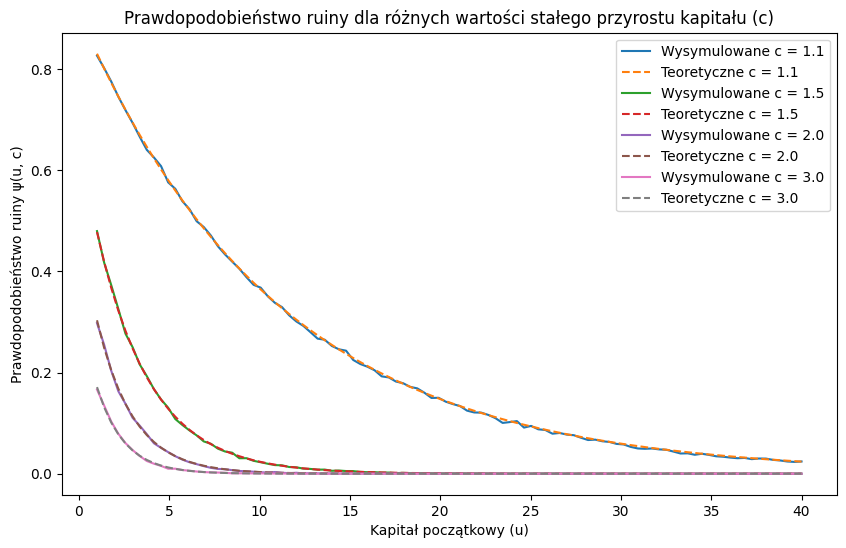

In [6]:
u_values = np.linspace(1, 40, 100)
c_values = [1.1, 1.5, 2.0, 3.0]  

plt.figure(figsize=(10, 6))
for c in c_values:
    psi_sim_values = [estimate_psi(u, c, lambd, eta, T, num_simulations) for u in u_values]
    psi_theoretical_values = [pollaczek_chinczyn_psi(u, c, lambd, eta) for u in u_values]
    
    plt.plot(u_values, psi_sim_values, label=f'Wysymulowane c = {c}')
    plt.plot(u_values, psi_theoretical_values, '--', label=f'Teoretyczne c = {c}')
    
plt.xlabel('Kapitał początkowy (u)')
plt.ylabel('Prawdopodobieństwo ruiny ψ(u, c)')
plt.legend()
plt.title('Prawdopodobieństwo ruiny dla różnych wartości stałego przyrostu kapitału (c)')
plt.show()

#### Wykres 2: Prawdopodobieństwo Ruiny dla różnych wartości kapitału początkowego (u)
W drugim wykresie analizujemy prawdopodobieństwo ruiny w zależności od stałej stawki wpłat 𝑐 dla różnych wartości kapitału początkowego 𝑢.

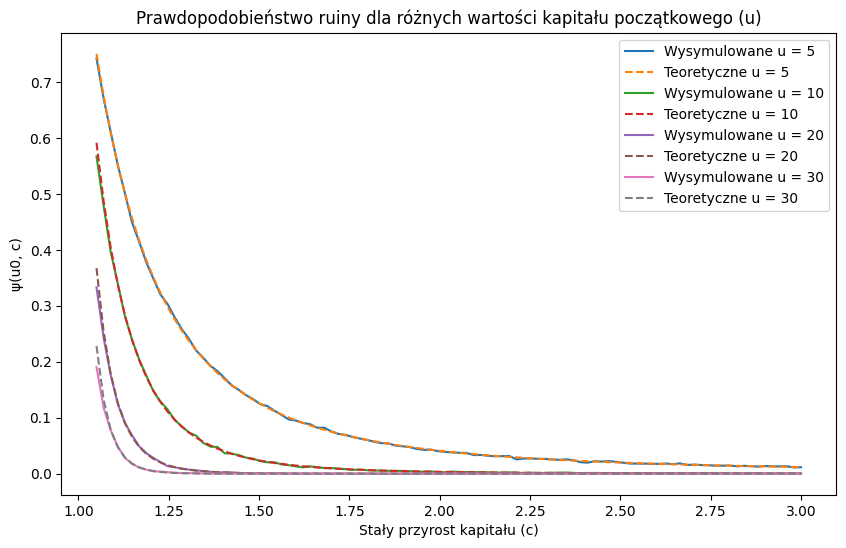

In [7]:
u0_values = [5, 10, 20, 30]
c_values_fine = np.linspace(1.05, 3, 100)

plt.figure(figsize=(10, 6))
for u0 in u0_values:
    psi_sim_values_fine = [estimate_psi(u0, c, lambd, eta, T, num_simulations) for c in c_values_fine]
    psi_theoretical_values_fine = [pollaczek_chinczyn_psi(u0, c, lambd, eta) for c in c_values_fine]

    plt.plot(c_values_fine, psi_sim_values_fine, label=f'Wysymulowane u = {u0}')
    plt.plot(c_values_fine, psi_theoretical_values_fine, '--', label=f'Teoretyczne u = {u0}')

plt.xlabel('Stały przyrost kapitału (c)')
plt.ylabel('ψ(u0, c)')
plt.legend()
plt.title('Prawdopodobieństwo ruiny dla różnych wartości kapitału początkowego (u)')
plt.show()

#### Wykres 3: Wymagana wartość stałej stawki wpłat dla różnych prawdopodobieństw ruiny
Natomiast w trzecim wykresie przedstawiamy zależność między stałą stawką wpłat 𝑐, a prawdopodobieństwem ruiny 𝜓 dla stałego kapitału początkowego $u_{0}$.

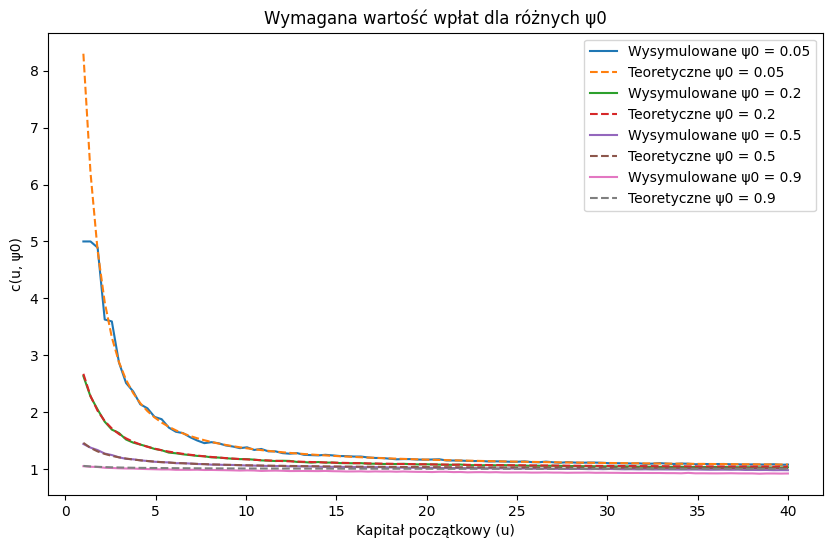

In [9]:
psi0_values = [0.05, 0.2, 0.5, 0.9]
u_values = np.linspace(1, 40, 100)

plt.figure(figsize=(10, 6))
for psi0 in psi0_values:
    c_values_teo = [inverse_c(u, psi0, lambd, eta) for u in u_values]
    c_values = [find_c(u, psi0, lambd, eta, T, num_simulations) for u in u_values]
    
    plt.plot(u_values, c_values, label=f'Wysymulowane ψ0 = {psi0}')
    plt.plot(u_values, c_values_teo, label=f'Teoretyczne ψ0 = {psi0}', linestyle='--')

plt.xlabel('Kapitał początkowy (u)')
plt.ylabel('c(u, ψ0)')
plt.legend()
plt.title('Wymagana wartość wpłat dla różnych ψ0')
plt.show()

W przeprowadzonych analizach porównaliśmy wyniki wyestymowanych wartości z ich teoretycznymi odpowiednikami. Wszystkie trajektorie dla przeprowadzonych symulacji pokrywają z oczekiwanymi wartościami dla zadanych parametrów, a więc uzyskane rezulaty potwierdzają poprawność zaimplementowanego modelu.

## 6: Prawa arcusa sinusa

### Cel
Weryfikacja symulacyjnie prawa arcusa sinusa dla procesu Wienera. W tym celu użyjemy porównania histogramów oraz
dystrybuant empirycznych wysymulowanych próbek z teoretycznymi wartościami.

### Rozwiązanie

#### Proces Wienera
Zaczniemy od implementacji procesu Wienera $W_t$ oraz stworzenia wykresu przykładowej trajektorii. Opisując po krótce ten proces jest on znany również jako ruch Browna. Jest procesem stochastycznym, który modeluje losowe zmiany w czasie, gdzie każda zmiana w krótkim okresie jest losowa i ma rozkład normalny. Można go opisać równaniem różniczkowym:
\begin{equation*}
dW(t)=ϵ\sqrt{dt},
​\end{equation*}
gdzie ϵ to zmienna losowa z rozkładem normalnym $N(0,1)$.

In [15]:
def wiener_process(n):
    """
    Generuje n liczb z procesu Wienera

    :param n: (int) liczba liczb do wygenerowania
    :return: (np.ndarray) n liczb z procesu Wienera
    """
    return np.concatenate((np.zeros(1), np.cumsum(norm_inv_cdf(n-1, 0, 1/n))))

Text(0.5, 1.0, 'Przykładowa trajektoria realizacji procesu Wienera')

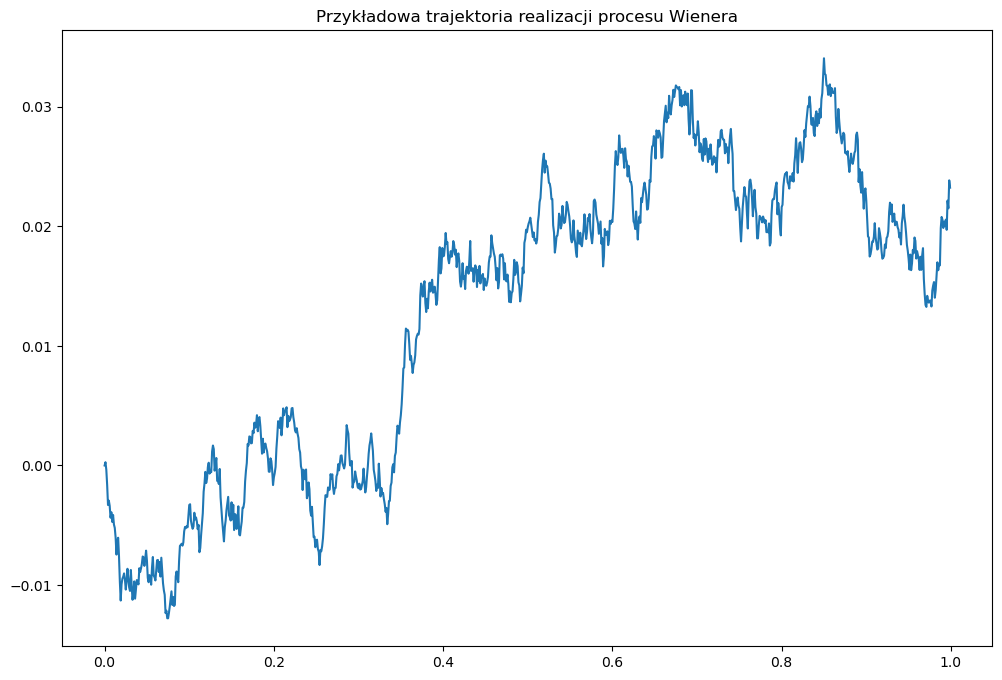

In [16]:
h = 0.001
fig, ax = plt.subplots()
ax.plot(np.arange(0, 1, h), wiener_process(1000), label='W_t')
ax.set_title('Przykładowa trajektoria realizacji procesu Wienera')

### Rozkład arcusa sinusa
Przechodząc dalej omówimy teraz pokrótce rozkład arcusa sinusa.

Niech $X$ będzie zmienną losową z rozkładu arcusa sinusa ($X$ ~ Arcsine). Wtedy jej gęstość wyraża się wzorem 
\begin{equation*}
    f(x) = \frac{1}{\pi\sqrt{x-x^2}}\mathbb{1}_{(0,1)}(x).
\end{equation*}
Z kolei dystrybuanta ma postać
\begin{equation*}
F(x) = \begin{cases}
0, & \text{gdy } x < 0,\\
\frac{2}{\pi}\arcsin\sqrt{x}, & \text{gdy } x = 0,\\
1, & \text{gdy } x < 0.
\end{cases}
\end{equation*}

In [144]:
f_arcsin = lambda x: 1 / (np.pi * np.sqrt(x - x**2))  # gęstość
F_arcsin = lambda x: 2 / np.pi * np.arcsin(np.sqrt(x))  # dystrybuanta

### I prawo arcusa sinusa

\begin{equation*}
 T_+ = \lambda(\{t \in [0,1] | W_t > 0\}) \sim \text{Arcsine},
\end{equation*}

gdzie $\lambda$ to miara Lebesgue'a. Stąd długość czasu, w którym proces znajdował się powyżej osi $OX$ ma rozkład arcusa sinusa.

C:\Users\Aleksandra\AppData\Local\Temp\ipykernel_7288\3346428493.py:1: RuntimeWarning: divide by zero encountered in divide
  f_arcsin = lambda x: 1 / (np.pi * np.sqrt(x - x**2))  # gęstość


Text(0.5, 1.0, 'Dystrybuanta')

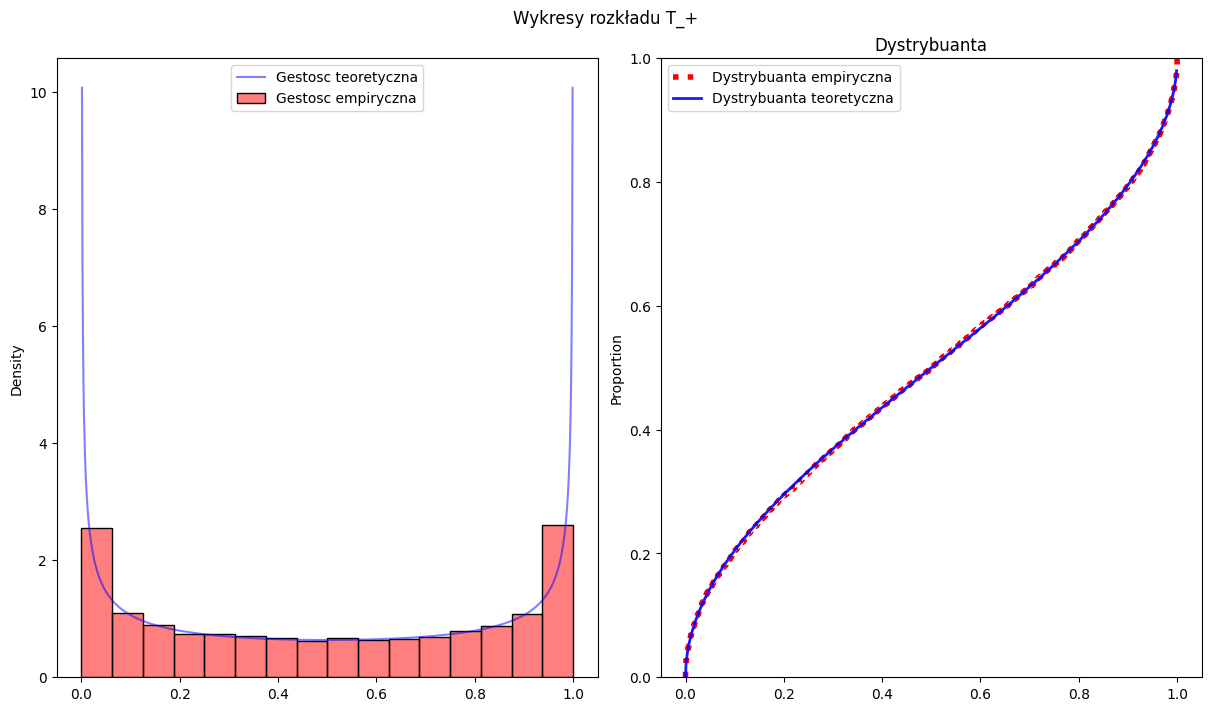

In [145]:
Ts = np.zeros(10000)
for i in range(10000):
    Xs = wiener_process(1000)
    Xs_pos = Xs[Xs > 0]
    Ts[i] = len(Xs_pos) / 1000

fig, axes = plt.subplots(ncols=2, layout="constrained")
sns.histplot(Ts, stat='density', color='red', alpha=0.5, ax=axes[0], label='Gestosc empiryczna')
sns.lineplot(x=np.unique(Ts), y=f_arcsin(np.unique(Ts)), color='blue', alpha=0.5, ax=axes[0],
             label='Gestosc teoretyczna')
sns.ecdfplot(Ts, ax=axes[1], color='red', linestyle=':', linewidth=4, label='Dystrybuanta empiryczna')
sns.lineplot(x=np.arange(0, 1, 0.001), y=F_arcsin(np.arange(0, 1, 0.001)), ax=axes[1], color='blue',
             label='Dystrybuanta teoretyczna', linewidth=2, alpha=0.9)
fig.suptitle('Wykresy rozkładu T_+')
# axes[0].set_title('Gęstość')
axes[1].set_title('Dystrybuanta')

## II prawo arcusa sinusa

\begin{equation}
 L = \text{sup}\{t\in [0,1] | W_t = 0\} \sim \text{Arcsine},
\end{equation}

czyli moment, w którym proces przecina oś $OX$ ma rozkład arcusa sinusa.

Text(0.5, 1.0, 'Dystrybuanta')

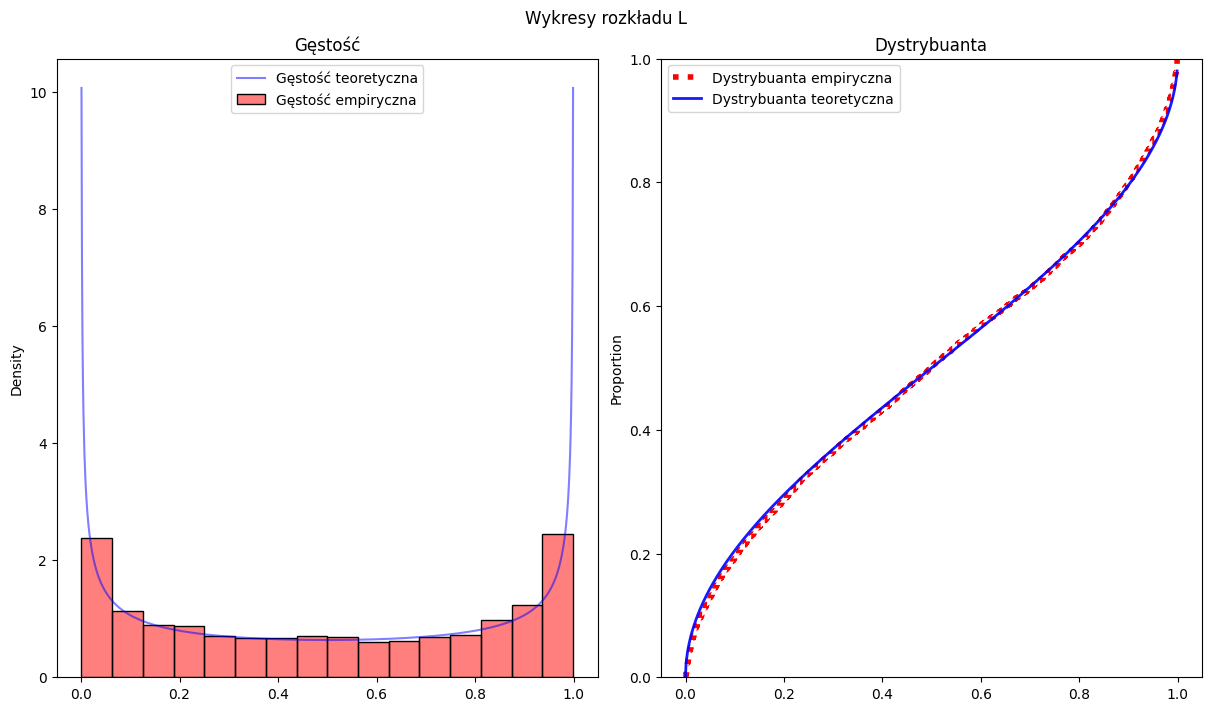

In [146]:
Ts = np.zeros(10000)
i = 0
while i != 10000:
    Xs = wiener_process(1000)
    if np.any(Xs > 0) and np.any(Xs < 0):
        Xs = Xs[:-1] * Xs[1:]
        Ts[i] = np.where(Xs < 0)[0][-1] / len(Xs)
        i += 1

fig, axes = plt.subplots(ncols=2, layout="constrained")
sns.histplot(Ts, stat='density', color='red', alpha=0.5, ax=axes[0], label='Gęstość empiryczna')
sns.lineplot(x=np.unique(Ts), y=f_arcsin(np.unique(Ts)), color='blue', alpha=0.5, ax=axes[0],
             label='Gęstość teoretyczna')
sns.ecdfplot(Ts, ax=axes[1], color='red', linestyle=':', linewidth=4, label='Dystrybuanta empiryczna')
sns.lineplot(x=np.arange(0, 1, 0.001), y=F_arcsin(np.arange(0, 1, 0.001)), ax=axes[1], color='blue',
             label='Dystrybuanta teoretyczna', linewidth=2, alpha=0.9)
fig.suptitle('Wykresy rozkładu L')
axes[0].set_title('Gęstość')
axes[1].set_title('Dystrybuanta')

### III prawo arcusa sinusa

\begin{equation}
 W_M = sup\{W_t | t\in [0,1]\},
\end{equation}

wtedy $M$ ~ Arcsine. Czyli moment, w którym proces osiąga maksymalną wartość ma rozkład arcusa sinusa.

C:\Users\Aleksandra\AppData\Local\Temp\ipykernel_7288\3346428493.py:1: RuntimeWarning: divide by zero encountered in divide
  f_arcsin = lambda x: 1 / (np.pi * np.sqrt(x - x**2))  # gęstość


Text(0.5, 1.0, 'Dystrybuanta')

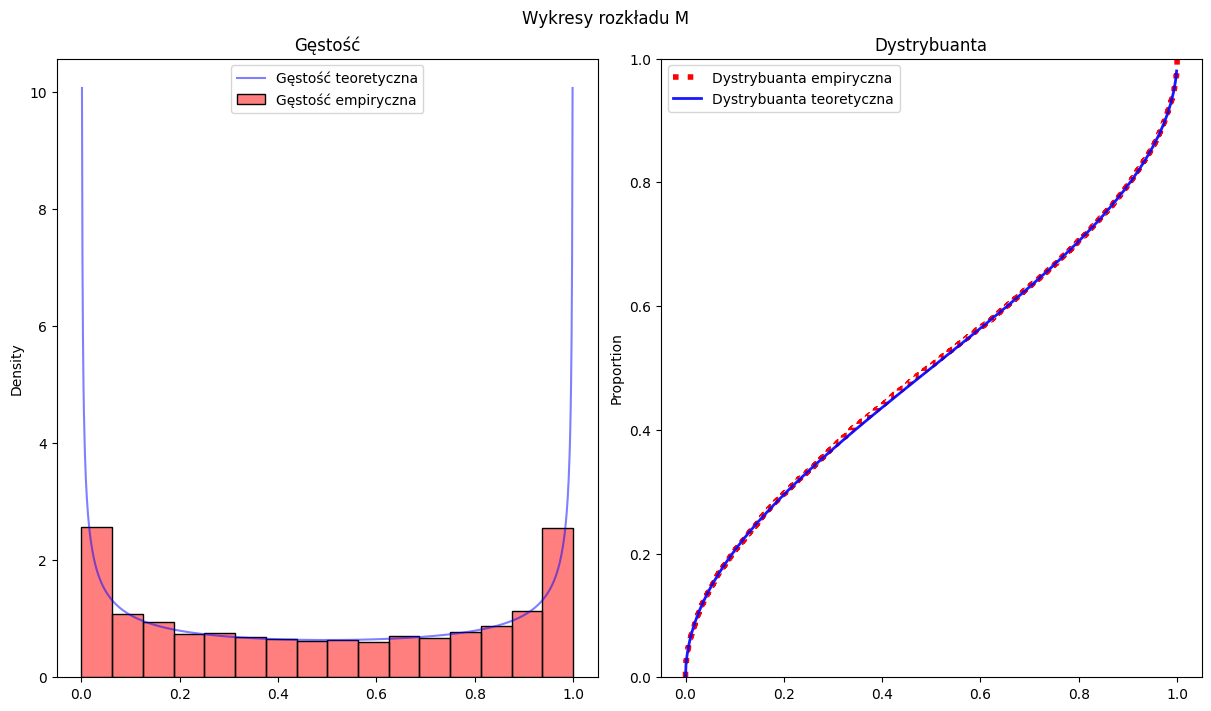

In [147]:
Ts = np.zeros(10000)
for i in range(10000):
    Xs = wiener_process(1000)
    Ts[i] = np.argmax(Xs) / 1000

fig, axes = plt.subplots(ncols=2, layout="constrained")
sns.histplot(Ts, stat='density', color='red', alpha=0.5, ax=axes[0], label='Gęstość empiryczna')
sns.lineplot(x=np.unique(Ts), y=f_arcsin(np.unique(Ts)), color='blue', alpha=0.5, ax=axes[0],
             label='Gęstość teoretyczna')
sns.ecdfplot(Ts, ax=axes[1], color='red', linestyle=':', linewidth=4, label='Dystrybuanta empiryczna')
sns.lineplot(x=np.arange(0, 1, 0.001), y=F_arcsin(np.arange(0, 1, 0.001)), ax=axes[1], color='blue',
             label='Dystrybuanta teoretyczna', linewidth=2, alpha=0.9)
fig.suptitle('Wykresy rozkładu M')
axes[0].set_title('Gęstość')
axes[1].set_title('Dystrybuanta')

Jak widać na wykresach, gęstości i dystrybuanty empiryczne tych trzech zmiennych losowych pokrywają się z gęstością i dystrybuantą rozkładu arcusa sinusa.

Dodatkowo dla domyślnych 20 realizacji zmiennych losowych przeprowadziliśmy test Kolmogorova-Smirnova przy użyciu funkcji $scipy.stats.kstest$. Statysyka testowa dla każdego z generatorów jest rzędu $10^{-1}$. P-wartości również są na podobnym poziomie. Biorąc pod uwagę poziom istotności testu $\alpha = 0.05$, nie mamy przesłanek do odrzucenia hipotezy zerowej ($H_0$ - realizacje pochodzą z rozkładu normalnego) dla żadnego z generatorów.

## Podsumowanie 
W powyższej pracy rozważyliśmy wszystkie zadane zagadnienia. Działania symulacyjne bez większych odchyleń pokazały poprawność implementacji. Korzystając z metod poznanych na zajęciach takich jak metoda odwrotnej dystrybuanty byliśmy w stanie rzeczowo podejść do problemów i zrealizować zadanie.